---
---
 <center>  <font color = '#125031' size = 6 face = "black body"> Modelo Analítico para Seleção da Melhor Ação de Cobrança </font> <center> 

---
---

---

<center> <font color='black' size=5 face="black body"> Descrição e Hipótese   </font> <center> 

Na área de Debt Collection, as contas não são pagas por diversos fatores:
* Esquecimento
* Restrições Financeiras
* Falhas técnicas...

Assim, o desafio da área de recuperação de débitos é aumentar a arrecadação ao menor custo possível, lidando com diferentes perfis de usuários por consumo, as ações possuem custos diferenciados e a existência de um roll de ações de cobrança.


**Hipótese: Qual a melhor ação de cobrança para um determinado cliente X?**

Para tanto, o objetivo do presente trabalho é ajustar um modelo de classificação para uma determinada ação de cobrança, no qual a partir de dados de perfil de pagamento do cliente, do histórico de ações de cobrança e de suas informações cadastrais/sociodemográficos seja possível estimar a probabilidade de um cliente reagir a ação de cobrança usada no estudo. 


Através dos modelos treinados para cada ação de cobrança de uma empresa, é possível que tais probabilidades associadas possam ser ajustadas no cálculo do Retorno Esperado da Ação de Cobrança.

Assim, é possível obter uma relação associada ao modelo **Next Best Action (NBA)**: identificar a ação mais relevante a ser tomada em relação a um cliente específico.

Fórmula sugerida:

ROI = [(Debt_customer * Prob(pagar)) - C(ação)]/C(ação)


Debt_customer = Dívida do cliente
Prob(pagar) = Probabilidade do cliente reagir à ação de cobrança - pagar a conta
C(ação) = custo da ação


**Observação: Foi utilizada uma base simulada de ações de cobrança para o estudo de referência.**


---

 <font color = '#125031' size = 6 face = "black body"> 1. Pacotes </font>

#### 1.1 Instalando Pacotes

In [ ]:
!pip install missingno
#pip install wordcloud -q
!pip install pandas_profiling

#### 1.2 Carregando bibliotecas - Tratamento de dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib # used for plots
import matplotlib.pyplot as plt
import missingno as msno # for checking missing values
import seaborn as sns # to plot...
import os # get current directory


#### 1.3 Carregando bibliotecas - Modelagem

In [2]:
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [3]:
os.getcwd()

'C:\\Users\\marco\\OneDrive\\Documentos\\.trabalho_pos_puc'

In [4]:
#os.listdir("base")
#os.listdir("base")[2]

 <font color = '#125031' size = 6 face = "black body"> 2. Pré-processamento dos dados </font>

Abaixo um resumo de etapas para o pré-processamento:

| Data Cleaning | Data Transformation | Data Reduction |
| --- | --- | --- |
| Valores Faltantes | Normalização | Redução de Dimensionalidade |
| Dados Anômalos (outliers, etc) | Criação de Atributos | Seleção de Atributos |
| - | Discretization | Data Aggregation|
| - | Hierarchy Transformation | - |

#### 2.1 Leitura da Base de Faturamento

In [5]:
base_master_table = pd.read_csv('base/MASTER_TABLE_4_v2_red.csv', sep = ";", encoding = 'latin_1')

In [6]:
base_backup = base_master_table.copy()

In [7]:
#base_master_table.head()

In [8]:
# Covnertendo data contrato no formato objeto para o formato date.time
base_master_table['DATA_REALIZADA'] = pd.to_datetime(base_master_table['DATA_REALIZADA'], errors='coerce') #, format='%B %d, %Y'
base_master_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478081 entries, 0 to 2478080
Columns: 117 entries, NUMCDC_VINCULADO to ano
dtypes: datetime64[ns](1), float64(12), int64(59), object(45)
memory usage: 2.2+ GB


In [9]:
base_master_table.columns #verificando o nome das colunas

Index(['NUMCDC_VINCULADO', 'NUMANO_REF', 'NUMMES_REF', 'VALLIQ_CTA',
       'DATA_REALIZADA', 'ACAO', 'QTD_ATRASO', 'EFETIVO', 'SMS', 'REAVISO',
       ...
       'MÉDIA DIAS ATRASO', 'MÉDIA COBRADO', 'AR', 'NUM_RECEITA_DIVERSA',
       'REAVISO AVULSO', 'REAVISO CONTA', 'COB. TERCEIRIZADA', 'Segment',
       'mes', 'ano'],
      dtype='object', length=117)

In [10]:
base_master_table.NUMCDC_VINCULADO.value_counts() #existem clientes

NUMCDC_VINCULADO
945803     4420
968149     1471
2285294    1016
1061109     463
324385      452
           ... 
3963954       1
2221551       1
3633149       1
796849        1
3129477       1
Name: count, Length: 183115, dtype: int64

In [11]:
base_master_table.rename(columns={'CODCLS_CSM':'CLASSE_CONSUMO',
                                'CODGRP_LTR':'GRUPO_LEITURA'}, 
                     inplace=True) #renomeando as colunas
#base_master_table.head()

In [12]:
#base_master_table.dtypes
base_master_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478081 entries, 0 to 2478080
Columns: 117 entries, NUMCDC_VINCULADO to ano
dtypes: datetime64[ns](1), float64(12), int64(59), object(45)
memory usage: 2.2+ GB


#### Procurando por valores faltantes

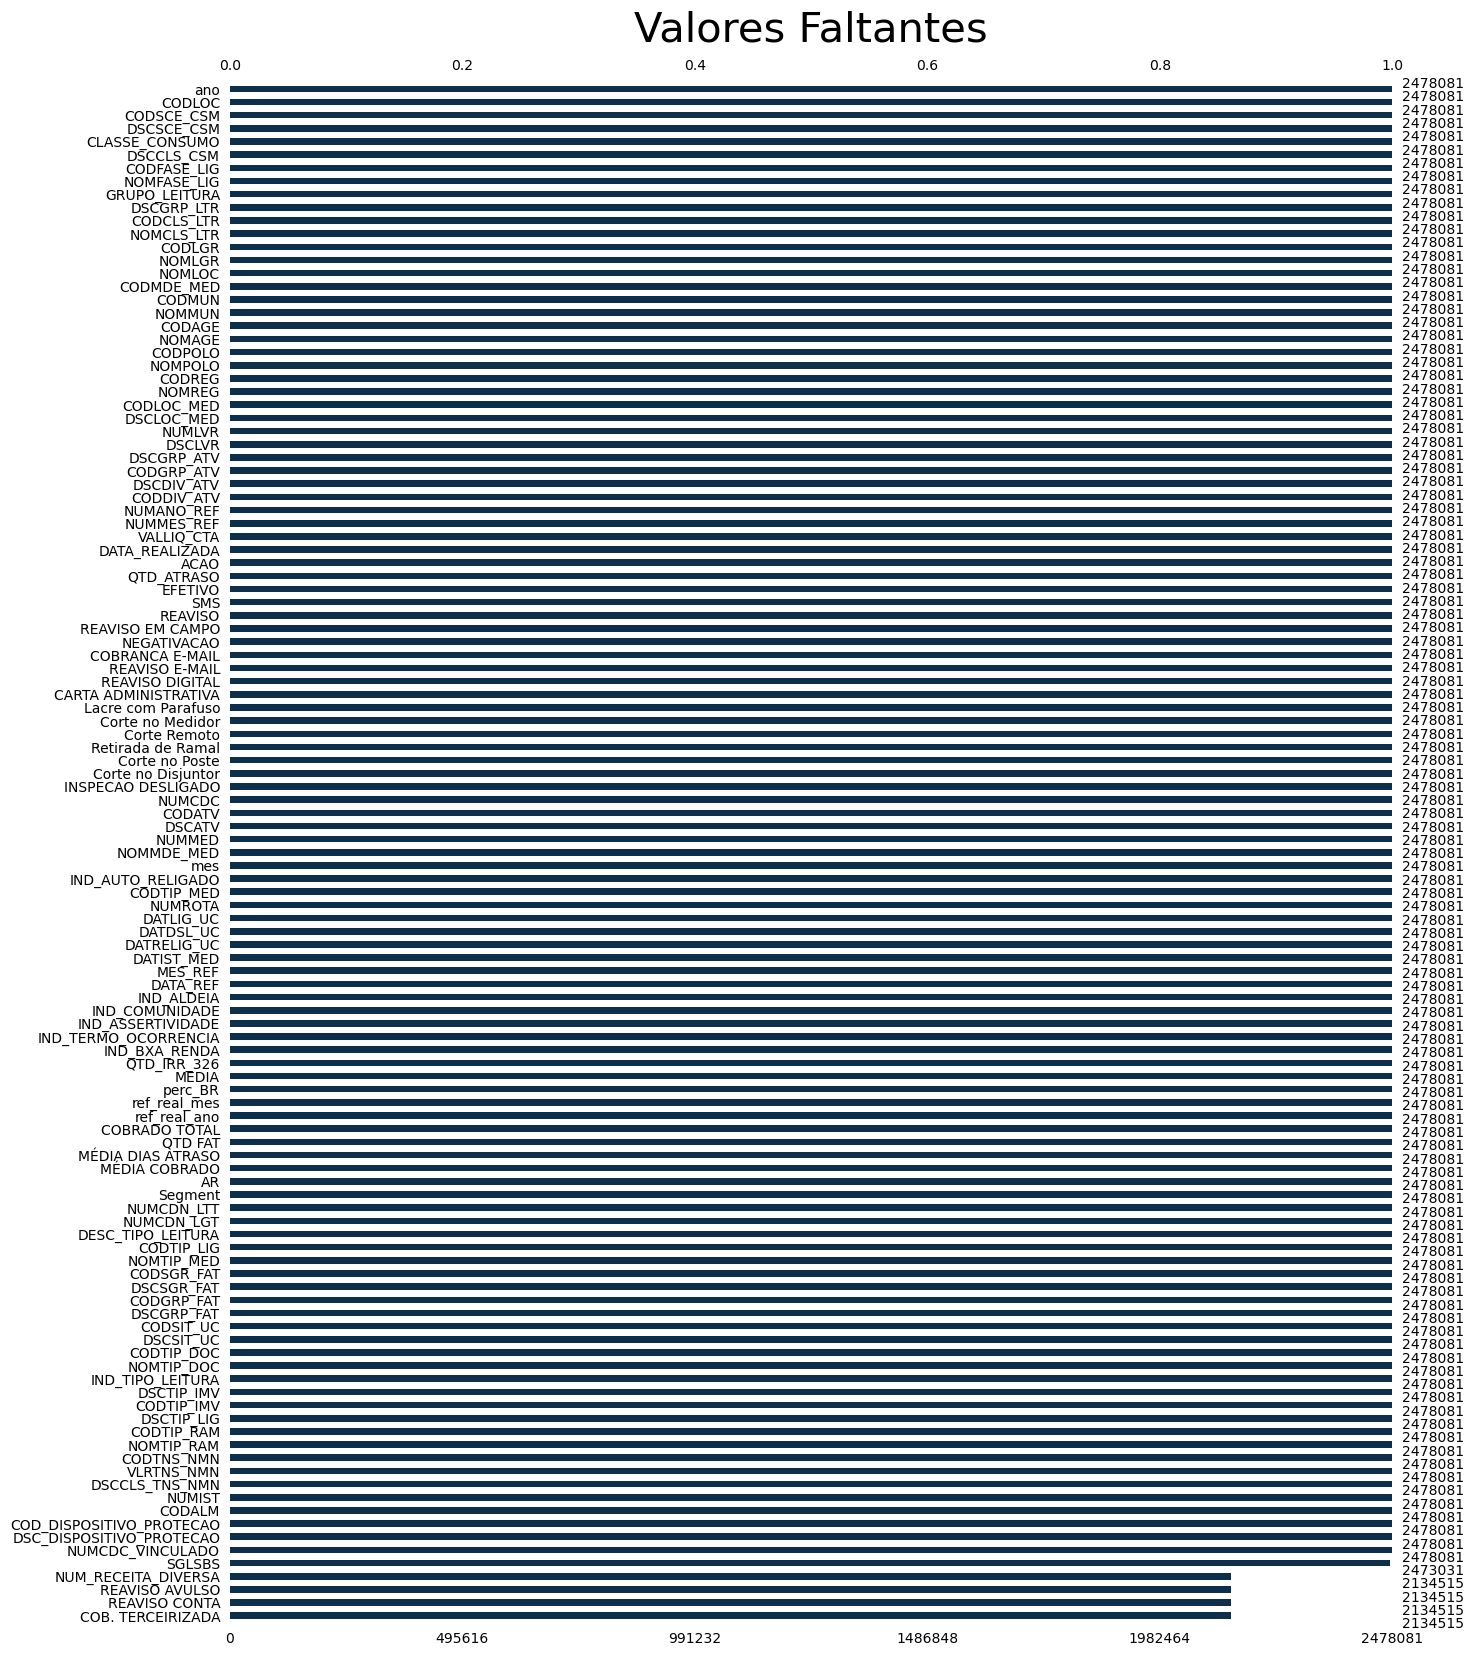

In [13]:
#msno.matrix(data) #- matrix
#msno.heatmap(data) #- heatmap
#msno.bar(data)# - bar plot
msno.bar(base_master_table, color="#0D2F4C", sort="ascending", figsize=(15,20), fontsize=10)
plt.title('Valores Faltantes', size = 30, pad=30)
plt.show() # - show plot/remove obs after running the plot

#### Verificando se há registros duplicados

In [14]:
[base_master_table.shape, base_master_table.size]

[(2478081, 117), 289935477]

In [15]:
base_master_table = base_master_table.drop_duplicates()

In [16]:
base_master_table.shape

(2472855, 117)

#### Análise Histograma - Dias de Atraso

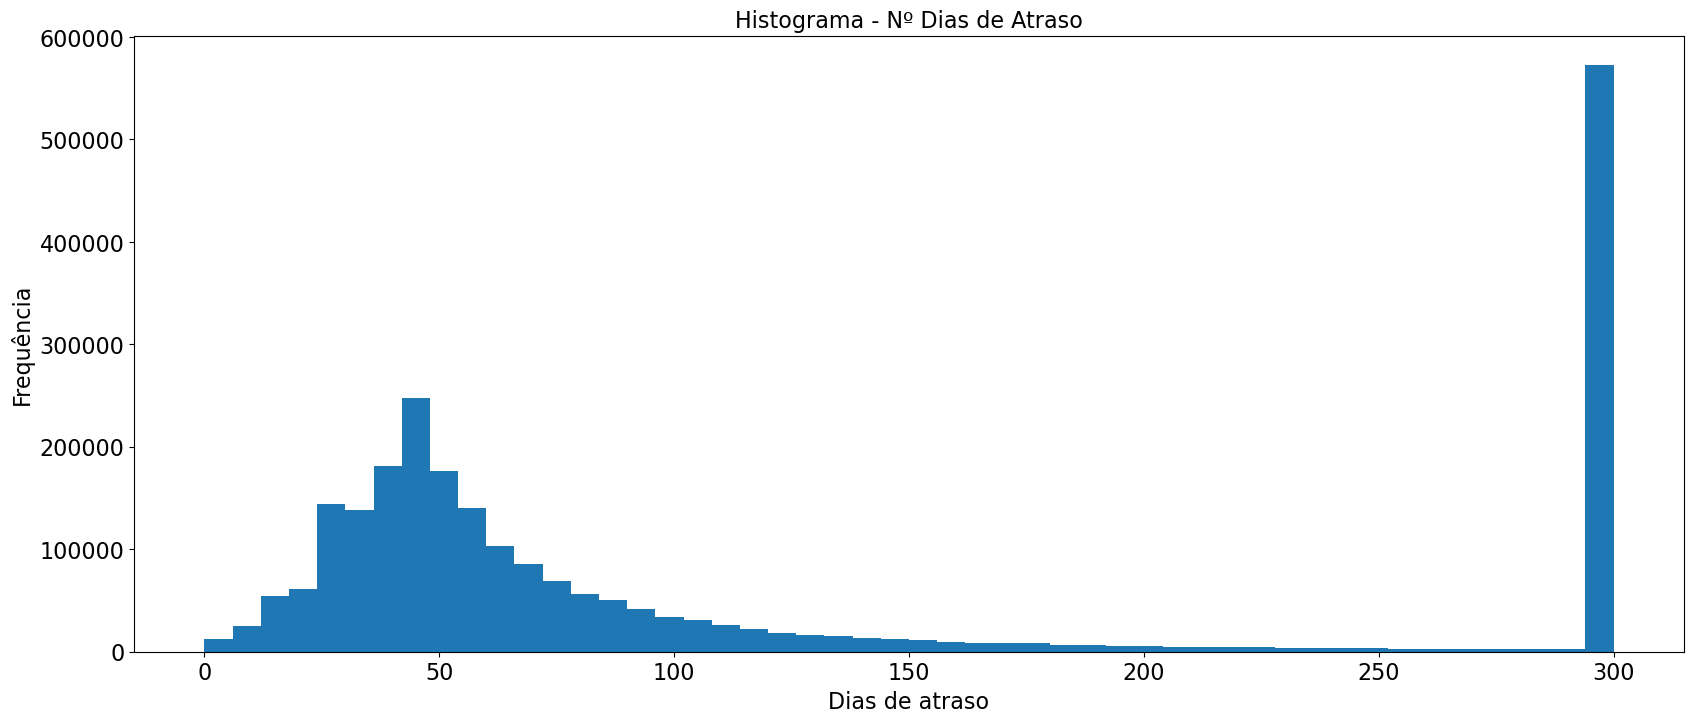

In [17]:
%matplotlib inline
fig, ax = plt.subplots(ncols=1,figsize=(20, 8))

plt.hist(np.clip(base_master_table['QTD_ATRASO'], 0, 300), density=False, bins=50)  # density=False would make counts
plt.ylabel('Frequência', size = 16)
plt.xlabel('Dias de atraso', size = 16);
plt.title('Histograma - Nº Dias de Atraso', size = 16)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.show()

In [18]:
base_master_table['QTD_ATRASO'][base_master_table['QTD_ATRASO'] <= 90]

0          73
1          73
2          73
4          73
6          73
           ..
2478076    41
2478077    41
2478078    41
2478079    41
2478080    41
Name: QTD_ATRASO, Length: 1556358, dtype: int64

In [19]:
base_master_table['QTD_ATRASO'][(base_master_table['QTD_ATRASO'] > 10) & (base_master_table['QTD_ATRASO'] <= 45)]

49         43
50         43
51         43
52         43
54         43
           ..
2478076    41
2478077    41
2478078    41
2478079    41
2478080    41
Name: QTD_ATRASO, Length: 769558, dtype: int64

In [20]:
base_master_table.iloc[:,3]

0          114.61
1          114.61
2          114.61
3           43.88
4          114.61
            ...  
2478076    192.54
2478077    192.54
2478078    192.54
2478079    192.54
2478080    192.54
Name: VALLIQ_CTA, Length: 2472855, dtype: float64

In [21]:
#%matplotlib inline 
#import matplotlib.pyplot as plt
#base_master_table.hist(bins=10, figsize = (20,55))
#plt.show()
#most simple way to create a graphic backend for matplotlib - it works only on Jupyter notebook

#### Registrando balanceamento de rótulos de saída

Definindo as ações consideradas efetivas:

In [22]:
base_master_table['ACAO_EFETIVA'] = np.where(base_master_table['EFETIVO'] == 'SIM',1,0)

In [23]:
base_master_table['IND_TOI'] = np.where(base_master_table['NUM_RECEITA_DIVERSA'] == 63,1,0)

In [24]:
base_master_table.IND_TOI.value_counts()

IND_TOI
0    2456656
1      16199
Name: count, dtype: int64

In [25]:
base_master_table.columns

Index(['NUMCDC_VINCULADO', 'NUMANO_REF', 'NUMMES_REF', 'VALLIQ_CTA',
       'DATA_REALIZADA', 'ACAO', 'QTD_ATRASO', 'EFETIVO', 'SMS', 'REAVISO',
       ...
       'AR', 'NUM_RECEITA_DIVERSA', 'REAVISO AVULSO', 'REAVISO CONTA',
       'COB. TERCEIRIZADA', 'Segment', 'mes', 'ano', 'ACAO_EFETIVA',
       'IND_TOI'],
      dtype='object', length=119)

In [26]:
# Criando uma funcao de conversao:

#def converte_funcao(tabela):
#    if tabela['EFETIVO'] == 'S':
#        val = 1
#    #elif
#    else:
#        val = 0
#    return val
#base_master_table['teste'] = base_master_table.apply(converte_funcao, axis=1)
#base_master_table = base_master_table.drop("teste", axis = 1) # axis =  0 para linhas e 1 para colunas

In [27]:
base_master_table['ACAO_EFETIVA'][base_master_table['ACAO_EFETIVA'] == 1]

9          1
52         1
53         1
62         1
64         1
          ..
2478050    1
2478053    1
2478055    1
2478068    1
2478069    1
Name: ACAO_EFETIVA, Length: 297448, dtype: int32

As ações de campo possuem maior balanceamento entre os rótulos de saída. Já as ações massivas, possuem maior volume de não reações em termos de efetividade, possivelmente por sua natureza de acionamento massivo. Uma estratégia para melhoria de performance dos modelos é testar o balanceamento do rótulo de saída para testar a hipótese do modelo conseguir identificar melhor perfil de acionamento de pagantes e não pagantes.

In [28]:
pd.DataFrame(base_master_table.groupby('AR').ACAO_EFETIVA.value_counts())

count
AR ACAO_EFETIVA         
0  0             2104942
   1              274557
1  0               70465
   1               22891

In [29]:
base_master_table.groupby('ACAO').ACAO_EFETIVA.value_counts()

ACAO                  ACAO_EFETIVA
CARTA ADMINISTRATIVA  0                  5413
                      1                   107
COB. TERCEIRIZADA     0                 87680
                      1                 43404
COBRANCA E-MAIL       0                305528
                      1                 21639
COBRANÇA SMS          0               1124104
                      1                 16367
COBRANÇA TELEFONE     0                    76
                      1                     4
Corte Remoto          1                  2100
                      0                  1975
Corte no Disjuntor    0                 84379
                      1                 78280
Corte no Medidor      1                 63519
                      0                 60878
Corte no Poste        0                 28907
                      1                 23528
NEGATIVAÇÃO           0                162974
                      1                 22953
REAVISO               0                   496

Aplicado Dicionário apra conversão de ações

In [31]:
base_master_table['ACAO'] = base_master_table['ACAO'].map(dic_class)

In [32]:
base_master_table.ACAO

0          acao_10
1           acao_4
2          acao_12
3           acao_4
4           acao_4
            ...   
2478076     acao_4
2478077     acao_4
2478078     acao_4
2478079    acao_12
2478080    acao_10
Name: ACAO, Length: 2472855, dtype: object

In [34]:
lista_saida_label = pd.DataFrame()
#lista_saida_label['antes'] = base_master_table.ACAO_EFETIVA.value_counts(dropna = False)
lista_saida_label['Efetividade'] = base_master_table.groupby('ACAO').ACAO_EFETIVA.value_counts(dropna = False,normalize=True) 
lista_saida_label
#type(lista_saida_label)
#base_master_table.groupby('ACAO').ACAO_EFETIVA.value_counts()

Efetividade
ACAO    ACAO_EFETIVA             
acao_1  0                0.980616
        1                0.019384
acao_10 0                0.876548
        1                0.123452
acao_11 0                0.992000
        1                0.008000
acao_12 0                0.905328
        1                0.094672
acao_13 0                0.954992
        1                0.045008
acao_14 0                0.959959
        1                0.040041
acao_15 0                0.943635
        1                0.056365
acao_2  0                0.668884
        1                0.331116
acao_3  0                0.933859
        1                0.066141
acao_4  0                0.985649
        1                0.014351
acao_5  0                0.950000
        1                0.050000
acao_6  1                0.515337
        0                0.484663
acao_7  0                0.518748
        1                0.481252
acao_8  1                0.510615
        0                0.489385
acao_9  0                0.551292
        1                0.448708

#### Identificando Outliers

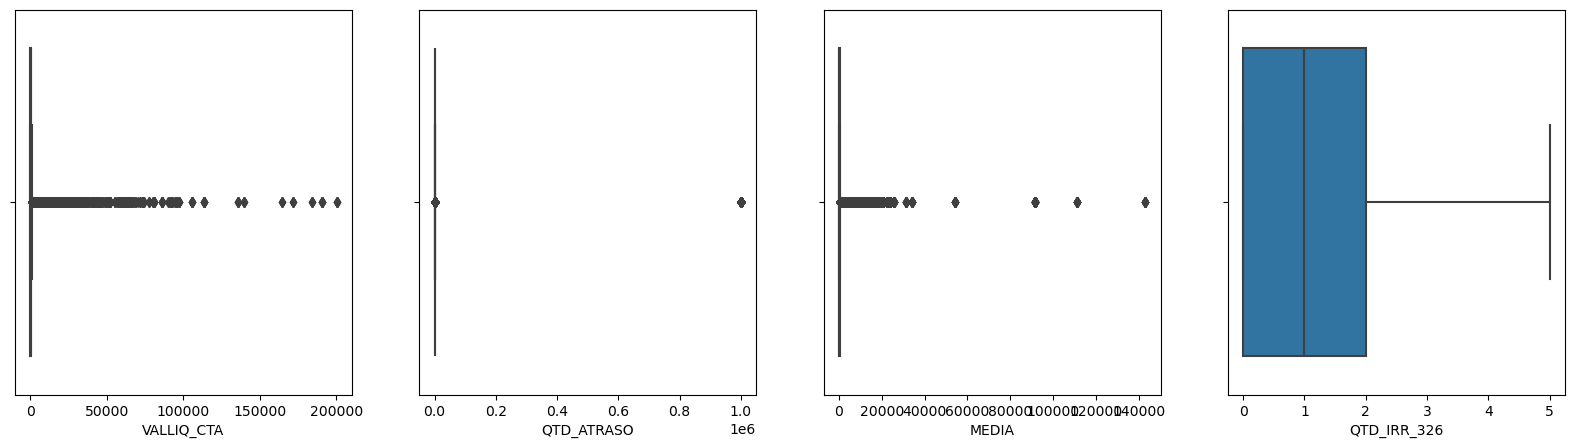

In [35]:
fig, axs = plt.subplots(ncols=4,figsize=(20, 5))  #sns.regplot(x='value', y='wage', data=df_melt, ax=axs[0])
sns.boxplot(x=base_master_table['VALLIQ_CTA'],ax=axs[0])
sns.boxplot(x=base_master_table['QTD_ATRASO'],ax=axs[1])
sns.boxplot(x=base_master_table['MEDIA'],ax=axs[2])
sns.boxplot(x=base_master_table['QTD_IRR_326'],ax=axs[3])
plt.show()

In [36]:
# Função de remoção de outliers
def remove_outlier(dtframe, col_name):   ### function to remove outliers
    q1 = dtframe[col_name].quantile(0.25)
    q3 = dtframe[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    dtframe_out = dtframe.loc[(dtframe[col_name] > fence_low) & (dtframe[col_name] < fence_high)]
    return dtframe_out

In [37]:
#remove_outlier(base_master_table,'VALLIQ_CTA')

#### Estatísticas Adicionais

In [38]:
#base_master_table = base_master_table.groupby(['NUMCDC']).mean()

In [39]:
#base_master_table[['NUMCDC_VINCULADO','VALLIQ_CTA']].groupby(['NUMCDC_VINCULADO']).sum().sort_values(ascending=False, by = 'VALLIQ_CTA')

In [40]:
#base_master_table.groupby(['NUMCDC_VINCULADO']).describe()

#### Realizando Filtros e Localizando informações

In [41]:
base_master_table['ACAO_EFETIVA'][base_master_table['ACAO_EFETIVA'] == 0]

0          0
1          0
2          0
3          0
4          0
          ..
2478076    0
2478077    0
2478078    0
2478079    0
2478080    0
Name: ACAO_EFETIVA, Length: 2175407, dtype: int32

In [42]:
base_master_table[['ACAO_EFETIVA','EFETIVO']]
#base_master_table[['ACAO_EFETIVA']]
#base_master_table['ACAO_EFETIVA']

,ACAO_EFETIVA,EFETIVO
0,0,NAO
1,0,NAO
2,0,NAO
3,0,NAO
4,0,NAO
...,...,...
2478076,0,NAO
2478077,0,NAO
2478078,0,NAO
2478079,0,NAO


In [43]:
#base_master_table.iloc[9:25, 2:5]

In [44]:
base_master_table.iloc[0, 0]

1000040

In [45]:
#base_master_table.loc[(base_master_table['ACAO_EFETIVA'] == 1) & (base_master_table['ACAO'] == 'acao_7')]

In [46]:
#Índice
base_master_table.loc[0]

NUMCDC_VINCULADO                                 1000040
NUMANO_REF                                          2023
NUMMES_REF                                             9
VALLIQ_CTA                                        114.61
DATA_REALIZADA                       2023-10-05 00:00:00
                                    ...                 
Segment             4) Delays a few times, but many days
mes                                                   10
ano                                                 2023
ACAO_EFETIVA                                           0
IND_TOI                                                0
Name: 0, Length: 119, dtype: object

In [47]:
#Array de índices
#base_master_table.loc[[0,1,2]] 

In [48]:
#Podemos concluir que o iloc seleciona linhas e colunas por números, esta é uma boa definição para o recurso.


In [49]:
#base_master_table.iloc[0:5,-2]

In [50]:
#base_master_table.iloc[[0,1,2,5],-2]

## Preparando Master Table - Ação 7

Removendo Colunas Não Utilizadas

In [51]:
#base_master_table.head()

In [52]:
base_master_table.columns

Index(['NUMCDC_VINCULADO', 'NUMANO_REF', 'NUMMES_REF', 'VALLIQ_CTA',
       'DATA_REALIZADA', 'ACAO', 'QTD_ATRASO', 'EFETIVO', 'SMS', 'REAVISO',
       ...
       'AR', 'NUM_RECEITA_DIVERSA', 'REAVISO AVULSO', 'REAVISO CONTA',
       'COB. TERCEIRIZADA', 'Segment', 'mes', 'ano', 'ACAO_EFETIVA',
       'IND_TOI'],
      dtype='object', length=119)

In [53]:
master_table = base_master_table.loc[(base_master_table['ACAO'] == 'acao_7')]

In [54]:
#master_table.head()

In [55]:
import re

In [56]:
#master_table['Segment'][:master_table['Segment'].index(")")]

In [57]:
#master_table['Segment'] = 

In [58]:
base_corr = master_table[['VALLIQ_CTA',
                                 'QTD_ATRASO',
                                 'SMS','NEGATIVACAO',
                          'MÉDIA COBRADO','MÉDIA DIAS ATRASO','AR', 'MEDIA', 'perc_BR','ACAO_EFETIVA',
]]

In [59]:
master_table['acoes_campo'] = master_table['Corte no Medidor'] + master_table['Lacre com Parafuso'] + master_table['Corte Remoto'] + master_table['Retirada de Ramal'] + master_table['Corte no Poste'] + master_table['Corte no Disjuntor'] + master_table['INSPECAO DESLIGADO'] 

C:\Users\marco\AppData\Local\Temp\ipykernel_28804\4072589435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_table['acoes_campo'] = master_table['Corte no Medidor'] + master_table['Lacre com Parafuso'] + master_table['Corte Remoto'] + master_table['Retirada de Ramal'] + master_table['Corte no Poste'] + master_table['Corte no Disjuntor'] + master_table['INSPECAO DESLIGADO']


In [60]:
master_table['acoes_digitais'] = master_table['SMS'] + master_table['COBRANCA E-MAIL'] + master_table['REAVISO E-MAIL'] + master_table['REAVISO DIGITAL']

C:\Users\marco\AppData\Local\Temp\ipykernel_28804\1104286510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_table['acoes_digitais'] = master_table['SMS'] + master_table['COBRANCA E-MAIL'] + master_table['REAVISO E-MAIL'] + master_table['REAVISO DIGITAL']


In [61]:
master_table['acoes_administrativas'] = master_table['REAVISO EM CAMPO'] + master_table['NEGATIVACAO'] + master_table['CARTA ADMINISTRATIVA']

C:\Users\marco\AppData\Local\Temp\ipykernel_28804\3141983900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_table['acoes_administrativas'] = master_table['REAVISO EM CAMPO'] + master_table['NEGATIVACAO'] + master_table['CARTA ADMINISTRATIVA']


In [62]:
master_table['Segment'] = master_table['Segment'].str.split(")").str[0]

C:\Users\marco\AppData\Local\Temp\ipykernel_28804\3100905471.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_table['Segment'] = master_table['Segment'].str.split(")").str[0]


In [63]:
master_table.columns.tolist()

['NUMCDC_VINCULADO',
 'NUMANO_REF',
 'NUMMES_REF',
 'VALLIQ_CTA',
 'DATA_REALIZADA',
 'ACAO',
 'QTD_ATRASO',
 'EFETIVO',
 'SMS',
 'REAVISO',
 'REAVISO EM CAMPO',
 'NEGATIVACAO',
 'COBRANCA E-MAIL',
 'REAVISO E-MAIL',
 'REAVISO DIGITAL',
 'CARTA ADMINISTRATIVA',
 'Lacre com Parafuso',
 'Corte no Medidor',
 'Corte Remoto',
 'Retirada de Ramal',
 'Corte no Poste',
 'Corte no Disjuntor',
 'INSPECAO DESLIGADO',
 'NUMCDC',
 'CODATV',
 'DSCATV',
 'CODDIV_ATV',
 'DSCDIV_ATV',
 'CODGRP_ATV',
 'DSCGRP_ATV',
 'CODSCE_CSM',
 'DSCSCE_CSM',
 'CLASSE_CONSUMO',
 'DSCCLS_CSM',
 'CODFASE_LIG',
 'NOMFASE_LIG',
 'GRUPO_LEITURA',
 'DSCGRP_LTR',
 'CODCLS_LTR',
 'NOMCLS_LTR',
 'CODLGR',
 'NOMLGR',
 'CODLOC',
 'NOMLOC',
 'CODMUN',
 'NOMMUN',
 'CODAGE',
 'NOMAGE',
 'CODPOLO',
 'NOMPOLO',
 'CODREG',
 'NOMREG',
 'CODLOC_MED',
 'DSCLOC_MED',
 'NUMLVR',
 'DSCLVR',
 'NUMMED',
 'CODMDE_MED',
 'NOMMDE_MED',
 'CODTIP_MED',
 'NOMTIP_MED',
 'CODSGR_FAT',
 'DSCSGR_FAT',
 'CODGRP_FAT',
 'DSCGRP_FAT',
 'CODSIT_UC',
 'DSCSI

In [64]:
master_table = master_table[['VALLIQ_CTA',
                                 'QTD_ATRASO',
                             'MÉDIA DIAS ATRASO',
                             'MÉDIA COBRADO',
                                 'acoes_campo', 'acoes_digitais',
       'acoes_administrativas',
                                  'CLASSE_CONSUMO',
                                  'DSCLOC_MED',
                                  'DSCSIT_UC',
                                  'NOMTIP_RAM',
                                  'DSCGRP_LTR',
                                  'IND_BXA_RENDA',
                                  'IND_ALDEIA',
                                  'IND_COMUNIDADE',
                                  'Segment',
                                  'IND_TOI',
                             'AR',
                                  'perc_BR',
                                 'ACAO_EFETIVA'
]]

In [65]:
master_table.head()

,VALLIQ_CTA,QTD_ATRASO,MÉDIA DIAS ATRASO,MÉDIA COBRADO,acoes_campo,acoes_digitais,acoes_administrativas,CLASSE_CONSUMO,DSCLOC_MED,DSCSIT_UC,NOMTIP_RAM,DSCGRP_LTR,IND_BXA_RENDA,IND_ALDEIA,IND_COMUNIDADE,Segment,IND_TOI,AR,perc_BR,ACAO_EFETIVA
52,880.03,43,26.5,1058.77,1,0,0,3,Local indefinido.,DESLIGADO,Aereo Fio Rigido,B,N,0,0,11,0,0,0.000000,1
53,1091.83,10,26.5,1058.77,1,14,0,3,Local indefinido.,DESLIGADO,Aereo Fio Rigido,B,N,0,0,11,0,0,0.000000,1
80,114.11,48,33.0,142.18,1,0,0,1,Local indefinido.,DESLIGADO,Aereo Fio Rigido,B,N,0,0,13,0,1,0.070796,1
81,115.15,18,33.0,142.18,1,0,0,1,Local indefinido.,DESLIGADO,Aereo Fio Rigido,B,N,0,0,13,0,1,0.070796,1
93,147.09,1000000,28.5,151.12,1,2,0,1,Local indefinido.,DESLIGADO,Aereo Fio Rigido,B,N,0,0,12,0,1,0.070796,0


 <font color = '#125031' size = 6 face = "black body"> 3. Modelagem dos dados </font>

#### 3.1 Identificando a efetividade por ação - Modelo mais 'naive' possível

**Proabilidade de reagir a uma ação de cobrança**
Nesta abordagem, vamos apenas identificar a efetividade das ações de cobrança com base no histórico de ações realizadas



In [67]:
master_table.head()

,VALLIQ_CTA,QTD_ATRASO,MÉDIA DIAS ATRASO,MÉDIA COBRADO,acoes_campo,acoes_digitais,acoes_administrativas,CLASSE_CONSUMO,DSCLOC_MED,DSCSIT_UC,NOMTIP_RAM,DSCGRP_LTR,IND_BXA_RENDA,IND_ALDEIA,IND_COMUNIDADE,Segment,IND_TOI,AR,perc_BR,ACAO_EFETIVA
52,880.03,43,26.5,1058.77,1,0,0,3,Local indefinido.,DESLIGADO,Aereo Fio Rigido,B,N,0,0,11,0,0,0.000000,1
53,1091.83,10,26.5,1058.77,1,14,0,3,Local indefinido.,DESLIGADO,Aereo Fio Rigido,B,N,0,0,11,0,0,0.000000,1
80,114.11,48,33.0,142.18,1,0,0,1,Local indefinido.,DESLIGADO,Aereo Fio Rigido,B,N,0,0,13,0,1,0.070796,1
81,115.15,18,33.0,142.18,1,0,0,1,Local indefinido.,DESLIGADO,Aereo Fio Rigido,B,N,0,0,13,0,1,0.070796,1
93,147.09,1000000,28.5,151.12,1,2,0,1,Local indefinido.,DESLIGADO,Aereo Fio Rigido,B,N,0,0,12,0,1,0.070796,0


In [68]:
base_efetividade_ar = (master_table.groupby('AR', as_index = False)
   .agg({'Segment':'count', 'ACAO_EFETIVA': 'sum'} )
   #.reset_index()
   .rename(columns={'Segment':'QTDE_ACOES',
                   'ACAO_EFETIVA':'QTDE_EFET_ACOES'})
)
base_efetividade_ar['EFETIVIDADE (%)'] = round(base_efetividade_ar.QTDE_EFET_ACOES/base_efetividade_ar.QTDE_ACOES*100,2)
base_efetividade_ar

,AR,QTDE_ACOES,QTDE_EFET_ACOES,EFETIVIDADE (%)
0,0,112044,65688,58.63
1,1,50615,12592,24.88


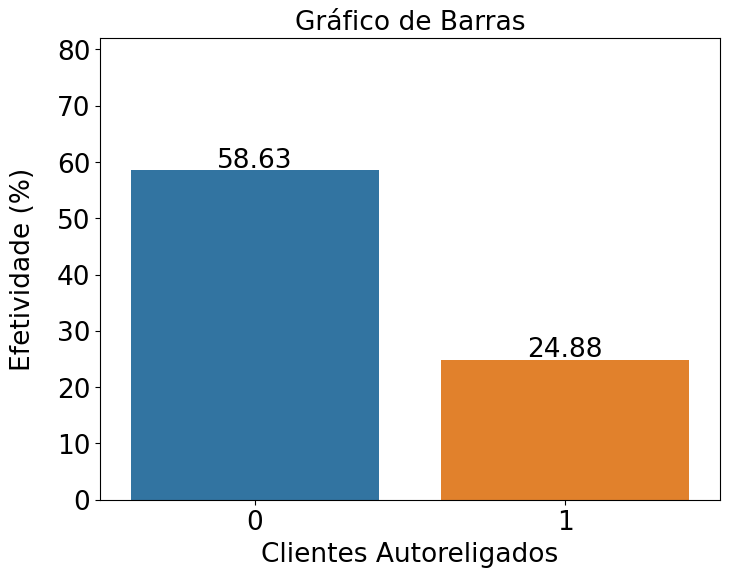

In [69]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Criar o gráfico de barras usando Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='AR', y='EFETIVIDADE (%)', data=base_efetividade_ar[['AR','EFETIVIDADE (%)']])

# Adicionar rótulos de dados
for index, row in base_efetividade_ar.iterrows():
    plt.text(index, row['EFETIVIDADE (%)'] + 0.5, str(row['EFETIVIDADE (%)']), color='black', ha='center', fontsize=19)


# Adicionar rótulos
plt.xlabel('Clientes Autoreligados', fontsize =19)
plt.ylabel('Efetividade (%)', fontsize =19, labelpad = 15)
plt.title('Gráfico de Barras', fontsize =19)

plt.ylim(0, max(base_efetividade_ar['EFETIVIDADE (%)']) * 1.4)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
# Mostrar o gráfico
plt.show()

In [71]:
base_efetividade_br = (master_table.groupby('IND_BXA_RENDA', as_index = False)
   .agg({'Segment':'count', 'ACAO_EFETIVA': 'sum'} )
   #.reset_index()
   .rename(columns={'Segment':'QTDE_ACOES',
                   'ACAO_EFETIVA':'QTDE_EFET_ACOES'})
)
base_efetividade_br['EFETIVIDADE (%)'] = round(base_efetividade_br.QTDE_EFET_ACOES/base_efetividade_br.QTDE_ACOES*100,2)
base_efetividade_br

,IND_BXA_RENDA,QTDE_ACOES,QTDE_EFET_ACOES,EFETIVIDADE (%)
0,N,139399,67698,48.56
1,S,23260,10582,45.49


In [72]:
base_efetividade_br[['IND_BXA_RENDA','EFETIVIDADE (%)']]

,IND_BXA_RENDA,EFETIVIDADE (%)
0,N,48.56
1,S,45.49


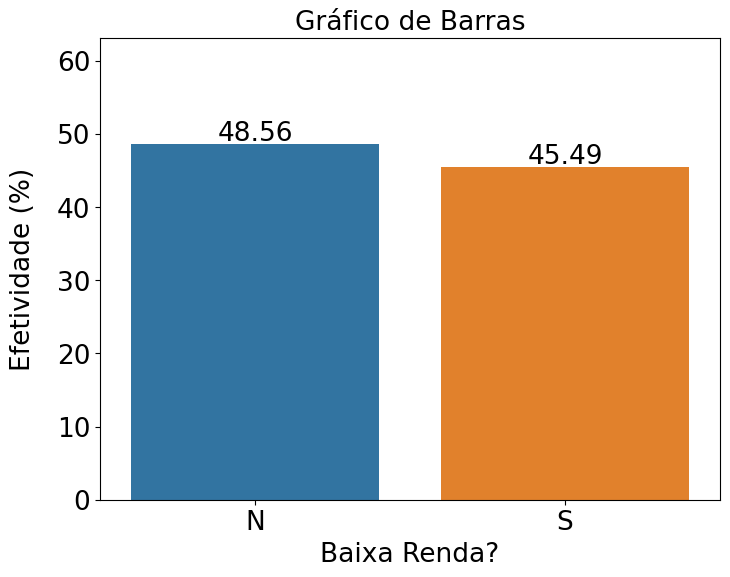

In [73]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Criar o gráfico de barras usando Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='IND_BXA_RENDA', y='EFETIVIDADE (%)', data=base_efetividade_br[['IND_BXA_RENDA','EFETIVIDADE (%)']])

# Adicionar rótulos de dados
for index, row in base_efetividade_br.iterrows():
    plt.text(index, row['EFETIVIDADE (%)'] + 0.5, str(row['EFETIVIDADE (%)']), color='black', ha='center', fontsize=19)


# Adicionar rótulos
plt.xlabel('Baixa Renda?', fontsize =19)
plt.ylabel('Efetividade (%)', fontsize =19, labelpad = 15)
plt.title('Gráfico de Barras', fontsize =19)

plt.ylim(0, max(base_efetividade_br['EFETIVIDADE (%)']) * 1.3)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
# Mostrar o gráfico
plt.show()

In [74]:
base_corr = master_table[[ 'MÉDIA COBRADO','MÉDIA DIAS ATRASO','ACAO_EFETIVA',
]]

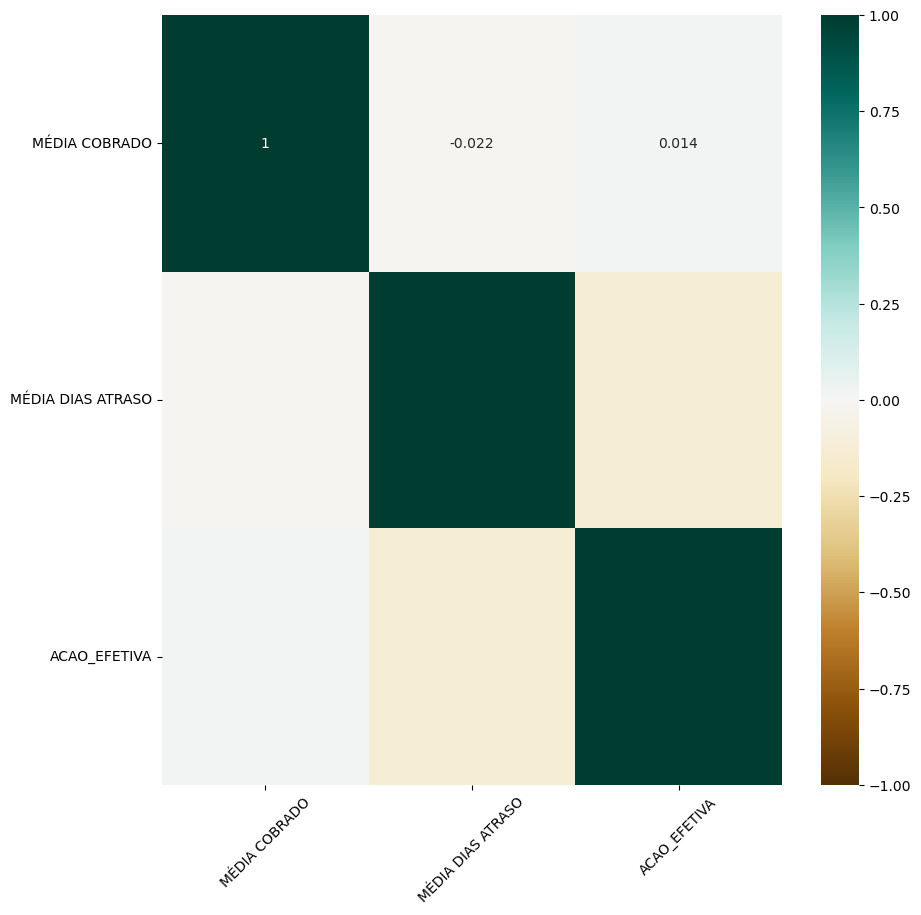

In [75]:
#análise de correlação
import seaborn as sns
plt.figure(figsize=(10,10))
corr = base_corr.iloc[:,0:5].corr()
#mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,cmap='BrBG',vmin=-1,vmax=1, yticklabels=True, annot = True)
#sns.heatmap(corr,cmap='BrBG',vmin=-1,vmax=1, yticklabels=True, annot = True);#BrBG,YlGnBu
#plt.savefig('corr.jpg')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [76]:
base_efetividade_acoes = (base_master_table.groupby('ACAO', as_index = False)
   .agg({'NUMCDC_VINCULADO':'count', 'ACAO_EFETIVA': 'sum'} )
   #.reset_index()
   .rename(columns={'NUMCDC_VINCULADO':'QTDE_ACOES',
                   'ACAO_EFETIVA':'QTDE_EFET_ACOES'})
)

base_efetividade_acoes['EFETIVIDADE (%)'] = base_efetividade_acoes.QTDE_EFET_ACOES/base_efetividade_acoes.QTDE_ACOES*100
base_efetividade_acoes

,ACAO,QTDE_ACOES,QTDE_EFET_ACOES,EFETIVIDADE (%)
0,acao_1,5520,107,1.938406
1,acao_10,185927,22953,12.345168
2,acao_11,500,4,0.800000
3,acao_12,212375,20106,9.467216
4,acao_13,33594,1512,4.500804
5,acao_14,79194,3171,4.004091
6,acao_15,13377,754,5.636540
7,acao_2,131084,43404,33.111593
8,acao_3,327167,21639,6.614053
9,acao_4,1140471,16367,1.435109


In [77]:
i = base_efetividade_acoes.loc[(base_efetividade_acoes['ACAO'] == 'COB. TERCEIRIZADA')].index

In [78]:
#base_efetividade_acoes.drop(i)
base_efetividade_acoes.sort_values(by='EFETIVIDADE (%)', ascending = False).drop(i)



,ACAO,QTDE_ACOES,QTDE_EFET_ACOES,EFETIVIDADE (%)
11,acao_6,4075,2100,51.533742
13,acao_8,124397,63519,51.061521
12,acao_7,162659,78280,48.125219
14,acao_9,52435,23528,44.870792
7,acao_2,131084,43404,33.111593
1,acao_10,185927,22953,12.345168
3,acao_12,212375,20106,9.467216
8,acao_3,327167,21639,6.614053
6,acao_15,13377,754,5.636540
10,acao_5,80,4,5.000000


In [80]:
base_corr = master_table[['VALLIQ_CTA',
                                 'QTD_ATRASO',
                          'MÉDIA COBRADO','MÉDIA DIAS ATRASO','AR', 'perc_BR','ACAO_EFETIVA',
]]

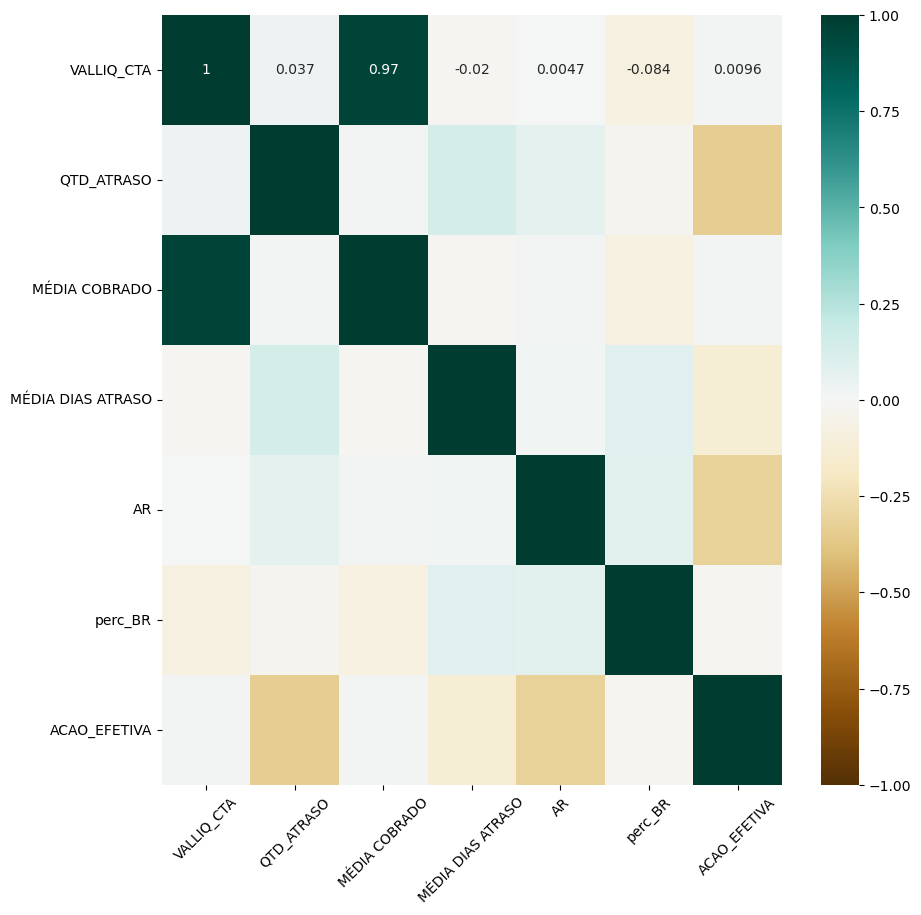

In [81]:
#análise de correlação
import seaborn as sns
plt.figure(figsize=(10,10))
corr = base_corr.iloc[:,0:10].corr()
#mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,cmap='BrBG',vmin=-1,vmax=1, yticklabels=True, annot = True)
#sns.heatmap(corr,cmap='BrBG',vmin=-1,vmax=1, yticklabels=True, annot = True);#BrBG,YlGnBu
#plt.savefig('corr.jpg')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [82]:
base_efetividade_acoes

,ACAO,QTDE_ACOES,QTDE_EFET_ACOES,EFETIVIDADE (%)
0,acao_1,5520,107,1.938406
1,acao_10,185927,22953,12.345168
2,acao_11,500,4,0.800000
3,acao_12,212375,20106,9.467216
4,acao_13,33594,1512,4.500804
5,acao_14,79194,3171,4.004091
6,acao_15,13377,754,5.636540
7,acao_2,131084,43404,33.111593
8,acao_3,327167,21639,6.614053
9,acao_4,1140471,16367,1.435109


In [83]:
base_efetividade_acoes['EFETIVIDADE (%)'] = base_efetividade_acoes.QTDE_EFET_ACOES/base_efetividade_acoes.QTDE_ACOES*100

In [84]:
base_efetividade_acoes

,ACAO,QTDE_ACOES,QTDE_EFET_ACOES,EFETIVIDADE (%)
0,acao_1,5520,107,1.938406
1,acao_10,185927,22953,12.345168
2,acao_11,500,4,0.800000
3,acao_12,212375,20106,9.467216
4,acao_13,33594,1512,4.500804
5,acao_14,79194,3171,4.004091
6,acao_15,13377,754,5.636540
7,acao_2,131084,43404,33.111593
8,acao_3,327167,21639,6.614053
9,acao_4,1140471,16367,1.435109


#### One-hot Encoding - Transformar variáveis categóricas em colunas com valores binários

In [85]:
#categorical data
categorical_cols = ['CLASSE_CONSUMO', 'DSCLOC_MED', 'DSCSIT_UC', 'NOMTIP_RAM', 'DSCGRP_LTR','IND_BXA_RENDA','Segment'] 

#import pandas as pd
master_table = pd.get_dummies(master_table, columns = categorical_cols)

In [86]:
#master_table.head()

In [87]:
#master_table.columns

In [88]:
#master_table.info()

 <font color = '#125031' size = 5 face = "black body"> Preparação dos dados </font>

 Nesta fase é importante garantir a separação dos dados em treino antes de realizar qualquer processo que interfira na relação de dados observados, como a normalização e o preenchimento de dados faltantes. Isso é importante para garantir o vazamento de informações (data leakage) entre dados de treino e dados de teste.

#### 3.2 Train Test Split

In [89]:
# same seed for reproduction and comparison of results
seed = 1
random.seed(seed)
np.random.seed(seed)

In [90]:
X = master_table.loc[:,master_table.columns != 'ACAO_EFETIVA']  # Entrada
y = master_table.ACAO_EFETIVA    # Saída
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

In [91]:
#X.columns

In [92]:
#extract_xtrain = pd.merge(X_train, base_master_table.loc[(base_master_table['ACAO'] == 'Corte no Disjuntor')][['NUMCDC_VINCULADO']], left_index=True, right_index=True)

In [93]:
#extract_xtrain.to_csv('X_train.csv', sep =';')

In [94]:
#extract_xtest = pd.merge(X_test, base_master_table.loc[(base_master_table['ACAO'] == 'Corte no Disjuntor')][['NUMCDC_VINCULADO']], left_index=True, right_index=True)

In [95]:
#extract_xtest.to_csv('X_test.csv', sep =';')

#### Data Standardization

Não foram realizadas em um primeiro momento ajustes de normalização nos valores das contas. 

Ainda assim, um ponto importante a se observar é que qualquer processo de normalização deve ser feito depois da separação das bases de treino e teste de forma a evitar o chamado data leakeage, em que há vazamento de informação e pode interferir diretamente no processo de treinamento dos modelos.

#### Criando Funções de Métricas

In [96]:
def predict_and_evaluate(X_test, y_test):

  y_pred = model.predict(X_test) #inference

  # Accuracy
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred)
  print('Accuracy: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred)
  print('Kappa: ', kappa)

  # Precision
  from sklearn.metrics import precision_score
  precision = precision_score(y_test, y_pred)
  print('Precision: ', precision)  
    
  # F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred, pos_label = 1)
  print('F1: ', f1)

  # Confusion matrix
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  y_pred = model.predict(X_test)
  confMatrix = confusion_matrix(y_pred, y_test)
  disp = ConfusionMatrixDisplay(confusion_matrix=confMatrix)
  disp.plot()

  plt.xlabel('Real')
  plt.ylabel('Previsto')
  plt.title('Matriz de Confusão')
 



In [97]:
from sklearn import metrics
def buildROC(y_test, y_pred):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

#### 3.3 Árvore de Decisão

In [98]:
from sklearn.tree import DecisionTreeClassifier

In [99]:
# training model
def train(X_train, y_train, seed):
  model = DecisionTreeClassifier(min_samples_leaf=3, random_state=seed) # tried 8 min sample leaf...
  model.fit(X_train, y_train);
  return model

model = train(X_train, y_train, seed)

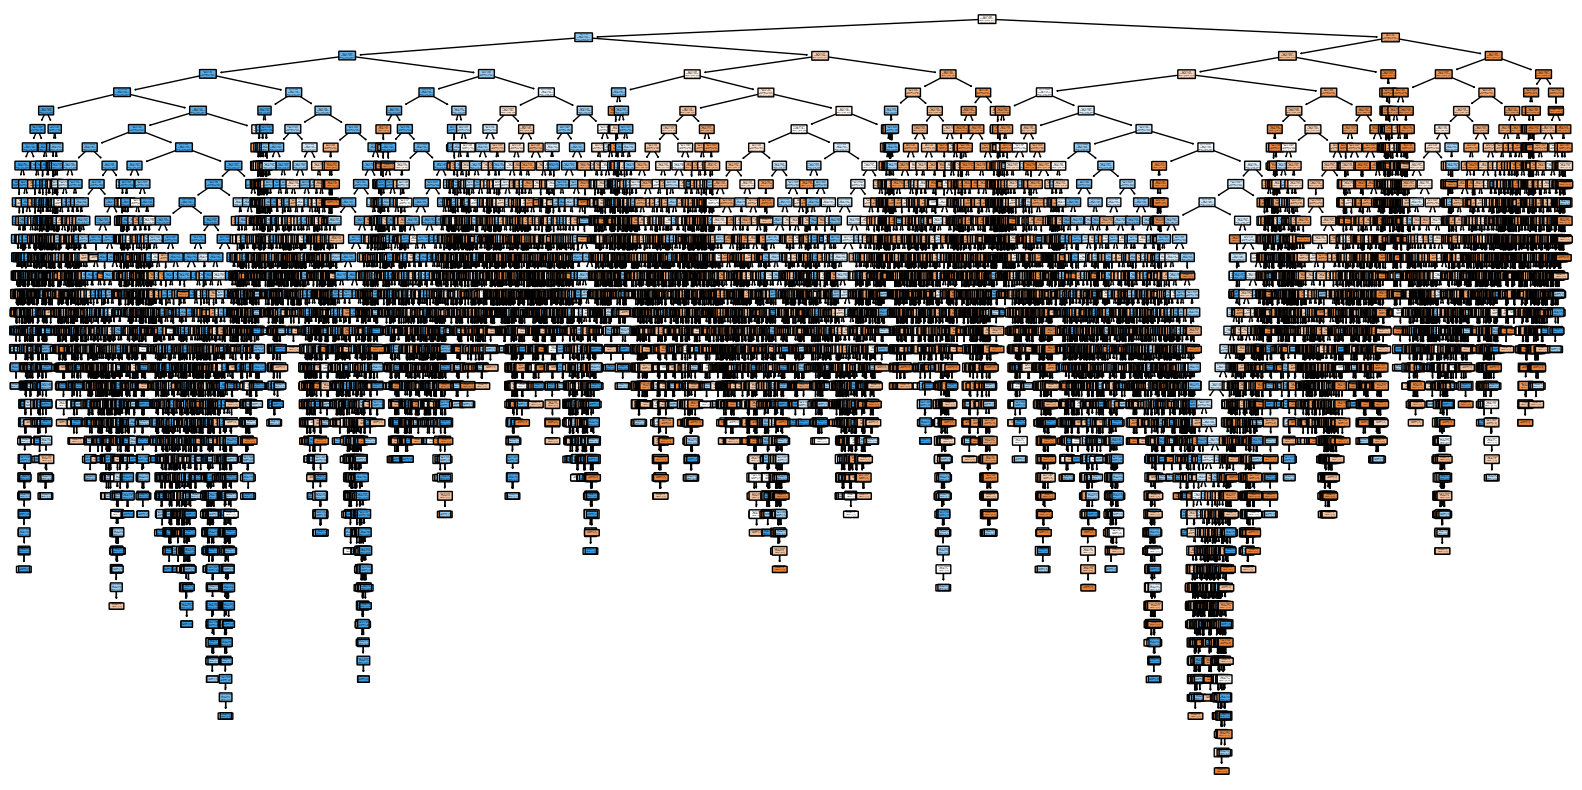

In [100]:
# Tree Plot visualization
from sklearn import tree
fig, ax = plt.subplots(figsize=(20, 10)) 
tree.plot_tree(model, class_names=['nao_efetivo','efetivo'], filled=True, rounded=True); 

In [101]:
#feature_names = [f"feature {i}" for i in range(X.shape[1])]

feature_names = X.columns

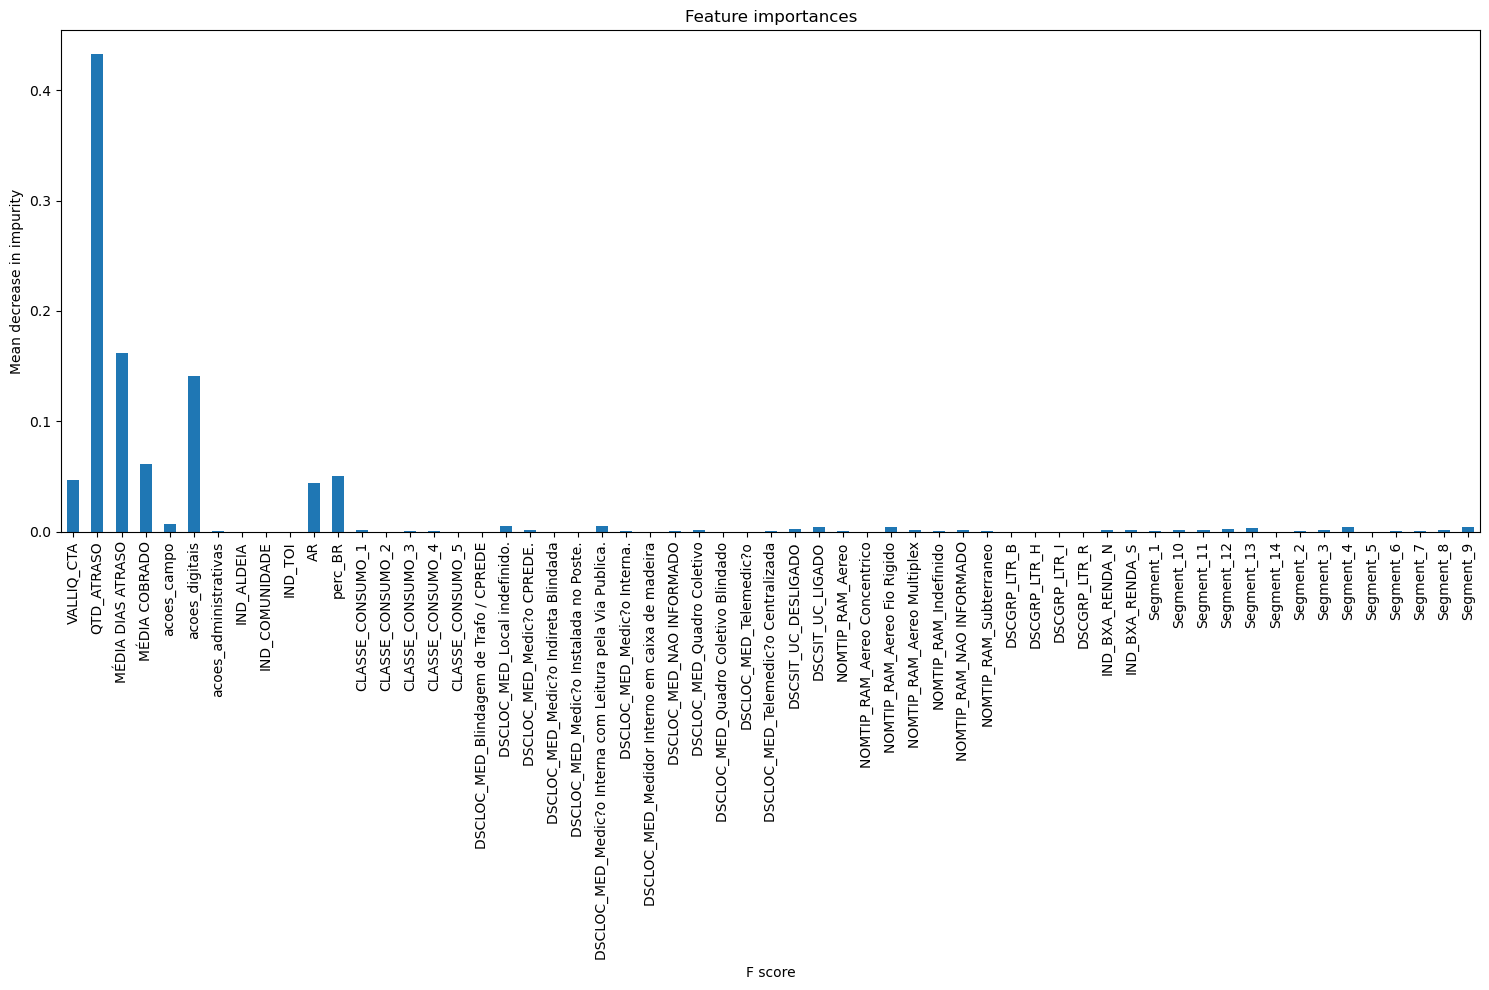

In [102]:
import numpy as np
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
#std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)


fig, ax = plt.subplots(figsize=(15,10))
forest_importances.plot.bar(ax=ax)
ax.set_ylabel('Features',fontsize = 10)
ax.set_xlabel('F score',fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#for i, v in enumerate(y):
#    ax.text(v + 3, i, str(y), color='black', size = 28)


Accuracy:  0.8457826140415591
Kappa:  0.6911301321222283
Precision:  0.839795592462472
F1:  0.8397687713583085


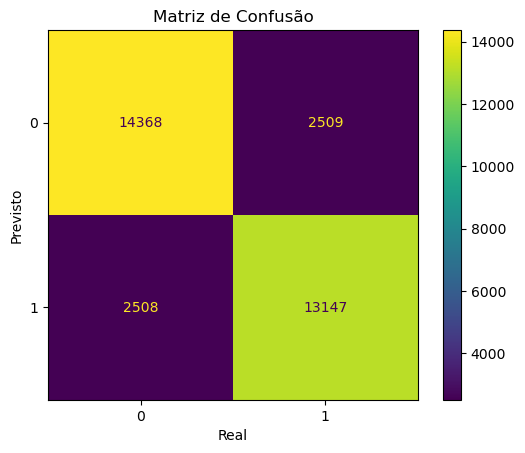

In [103]:
predict_and_evaluate(X_test, y_test)

In [104]:
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#y_pred = model.predict(X_test)
#confMatrix = confusion_matrix(y_pred, y_test)
#disp = ConfusionMatrixDisplay(confusion_matrix=confMatrix)
#disp.plot()

#plt.show()

In [105]:
y_test.value_counts()

ACAO_EFETIVA
0    16876
1    15656
Name: count, dtype: int64

**ROC Curve**

In [106]:
pd.DataFrame(model.predict(X_test)).value_counts()

0    16877
1    15655
Name: count, dtype: int64

In [107]:
model.predict(X_test)

array([0, 1, 1, ..., 1, 0, 1])

In [108]:
pd.DataFrame(model.predict_proba(X_test))

,0,1
0,0.666667,0.333333
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000000,1.000000
...,...,...
32527,1.000000,0.000000
32528,0.000000,1.000000
32529,0.000000,1.000000
32530,1.000000,0.000000


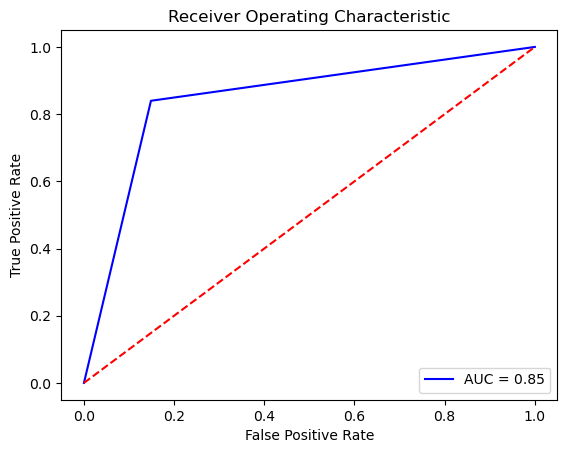

In [109]:
buildROC(y_test, model.predict(X_test))

#### Hiperparametrização - GridSearch

In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the parameters by cross-validation
tuned_parameters = [{'criterion': ['gini', 'entropy'], 'max_depth': [2,4,6,7,8,9,10,12],
                     'min_samples_leaf': [3, 4, 5, 8, 10,12]}] # using gridsearch to try different tuned parameters

print("# Tuning hyper-parameters for F1 score")
print()

model = GridSearchCV(DecisionTreeClassifier(), tuned_parameters) # scoring = 'precision'
model.fit(X_train, y_train)

y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))
print()

# Tuning hyper-parameters for F1 score

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     16876
           1       0.82      0.87      0.84     15656

    accuracy                           0.85     32532
   macro avg       0.85      0.85      0.85     32532
weighted avg       0.85      0.85      0.85     32532




Accuracy:  0.8454137464650191
Kappa:  0.6911841949298747
Precision:  0.8169022484642452
F1:  0.8448940566881534


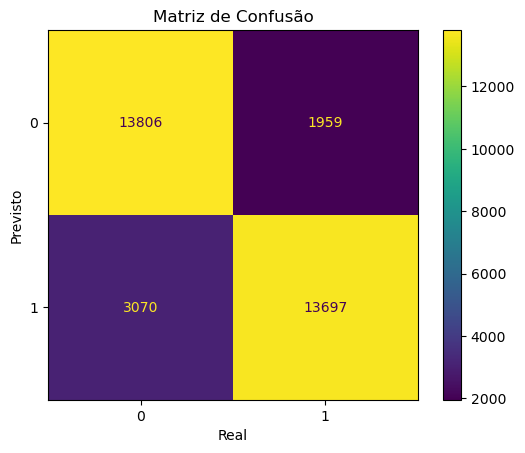

In [111]:
predict_and_evaluate(X_test, y_test)

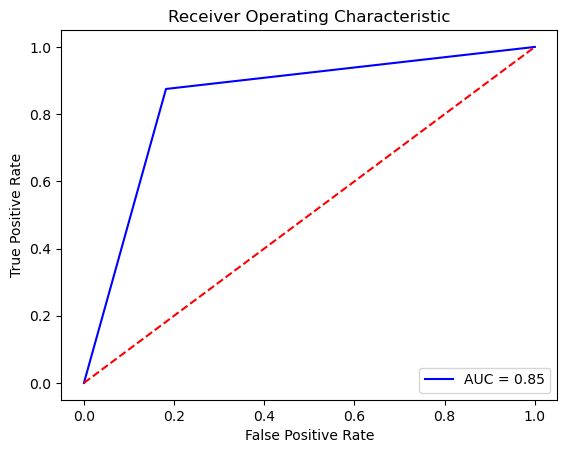

In [112]:
buildROC(y_test, model.predict(X_test))

In [113]:
model.best_params_

{'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 10}

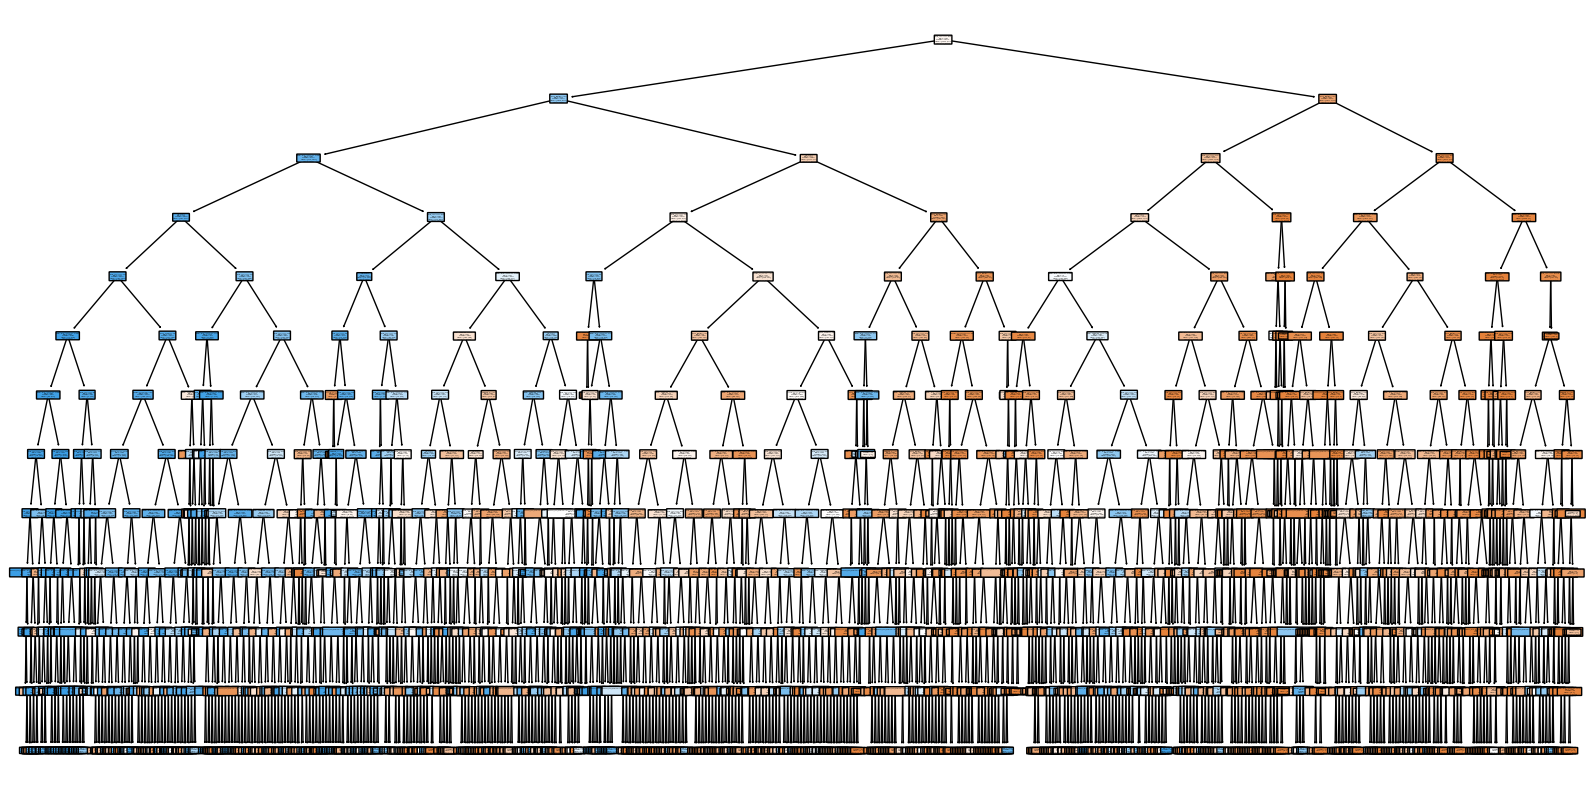

In [114]:
grid_col = X_train
fig, ax = plt.subplots(figsize=(20, 10)) 
tree.plot_tree(model.best_estimator_, class_names=['nao_efetivo','efetivo'], 
               filled=True, rounded=True, feature_names=grid_col.columns);

#### Hiperparametrização - RandomSearch

In [115]:
from scipy.stats import randint

rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'max_features':randint(1,7),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

In [116]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
#from scipy.stats import uniform
# Set the parameters by cross-validation
print("# Tuning hyper-parameters for F1 score")
print()
#distributions = dict(C=uniform(loc=0, scale=4),
#                        penalty=['l2', 'l1'])
model =RandomizedSearchCV(DecisionTreeClassifier(), rs_space, n_iter=500, n_jobs=-1, random_state=1) # scoring = 'precision'
model.fit(X_train, y_train)

# random random search results
print('A melhor busca de hiperparâmetros de forma aleatória é: '+str(model.best_params_))
print('O melhor score aleatório é: '+str(model.best_score_))

# Tuning hyper-parameters for F1 score

A melhor busca de hiperparâmetros de forma aleatória é: {'criterion': 'entropy', 'max_depth': 30, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 2}
O melhor score aleatório é: 0.8018244750889396


#### 3.4 Regressão Logística

In [117]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(
    solver='liblinear', 
    class_weight='balanced' # handle imbalanced classes
)
# fit the model on the training data 
model.fit(X_train, y_train)
# and then predict y for the test inputs 
y_test_predictions = model.predict(X_test)

Accuracy:  0.6755809664330505
Kappa:  0.3527913611215453
Precision:  0.6469639359373199
F1:  0.6803174410856


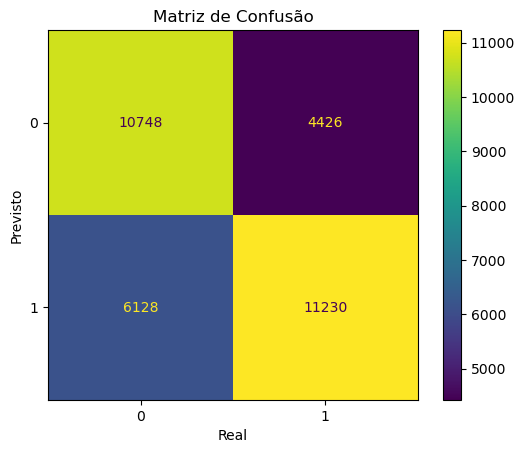

In [118]:
predict_and_evaluate(X_test, y_test)

In [119]:
pd.DataFrame(y_pred).value_counts()

1    16767
0    15765
Name: count, dtype: int64

In [120]:
pd.DataFrame(model.predict_proba(X_test))

,0,1
0,0.505782,0.494218
1,0.530646,0.469354
2,0.479773,0.520227
3,0.494137,0.505863
4,0.497266,0.502734
...,...,...
32527,1.000000,0.000000
32528,0.525810,0.474190
32529,0.490943,0.509057
32530,0.496188,0.503812


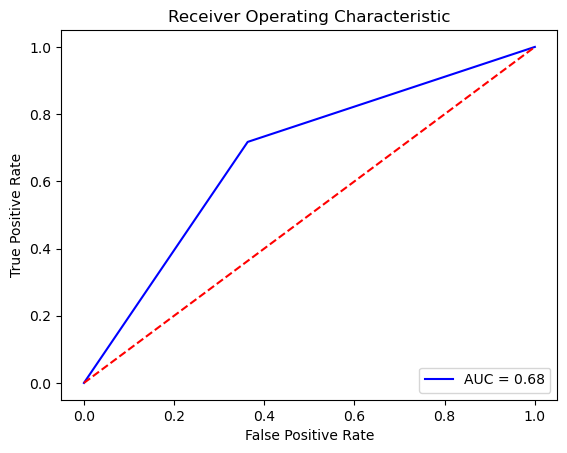

In [121]:
buildROC(y_test, model.predict(X_test))

#### 3.5 Random Forest

In [122]:
# training model
from sklearn.ensemble import RandomForestClassifier

def train(X_train, y_train, seed):
  model = RandomForestClassifier(min_samples_leaf=3, random_state=seed) 
  model.fit(X_train, y_train);
  return model

model = train(X_train, y_train, seed)

Accuracy:  0.8522685355957211
Kappa:  0.7045520567160426
Precision:  0.8330672888015717
F1:  0.8495492111194589


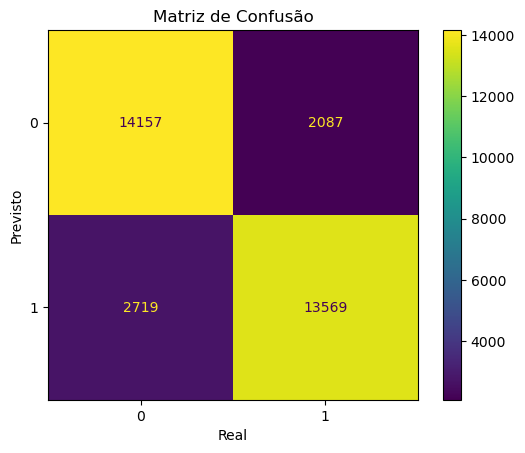

In [123]:
predict_and_evaluate(X_test, y_test)

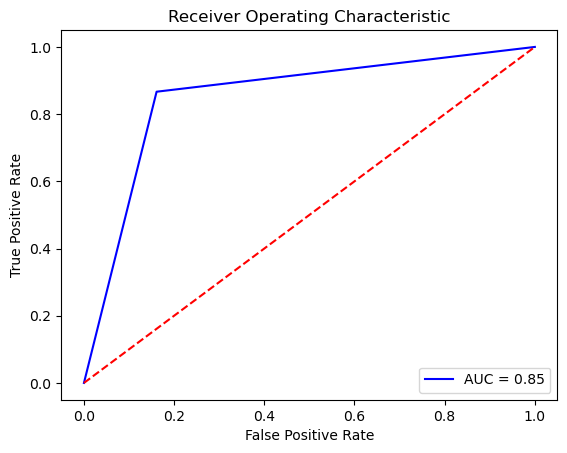

In [124]:
buildROC(y_test, model.predict(X_test))

#### 3.6 CatBoost

In [125]:
!pip install catboost

In [126]:
from catboost import CatBoostClassifier

# Create CatBoostClassifier
model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5)

# Fit model on training data
model.fit(X_train, y_train)

# Evaluate model on test data
score = model.score(X_test, y_test)
print(f"Accuracy: {score}")

0:	learn: 0.6180347	total: 179ms	remaining: 17.7s
1:	learn: 0.5680989	total: 199ms	remaining: 9.76s
2:	learn: 0.5293337	total: 225ms	remaining: 7.27s
3:	learn: 0.5042479	total: 239ms	remaining: 5.74s
4:	learn: 0.4856926	total: 255ms	remaining: 4.84s
5:	learn: 0.4683536	total: 269ms	remaining: 4.22s
6:	learn: 0.4553238	total: 283ms	remaining: 3.76s
7:	learn: 0.4460910	total: 296ms	remaining: 3.4s
8:	learn: 0.4374834	total: 309ms	remaining: 3.12s
9:	learn: 0.4309883	total: 321ms	remaining: 2.89s
10:	learn: 0.4256603	total: 333ms	remaining: 2.7s
11:	learn: 0.4213784	total: 345ms	remaining: 2.53s
12:	learn: 0.4173331	total: 357ms	remaining: 2.39s
13:	learn: 0.4140019	total: 369ms	remaining: 2.27s
14:	learn: 0.4121479	total: 378ms	remaining: 2.14s
15:	learn: 0.4099363	total: 389ms	remaining: 2.04s
16:	learn: 0.4078850	total: 401ms	remaining: 1.96s
17:	learn: 0.4045891	total: 412ms	remaining: 1.88s
18:	learn: 0.4016290	total: 423ms	remaining: 1.8s
19:	learn: 0.3986893	total: 435ms	remaining:

Accuracy:  0.8376060494282552
Kappa:  0.675329618542609
Precision:  0.8158070997990623
F1:  0.835312821471991


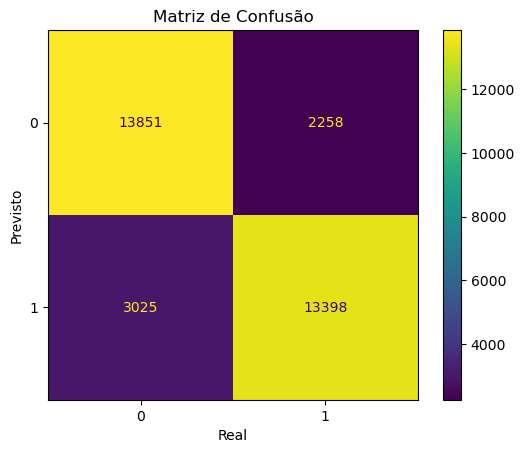

In [127]:
predict_and_evaluate(X_test, y_test)

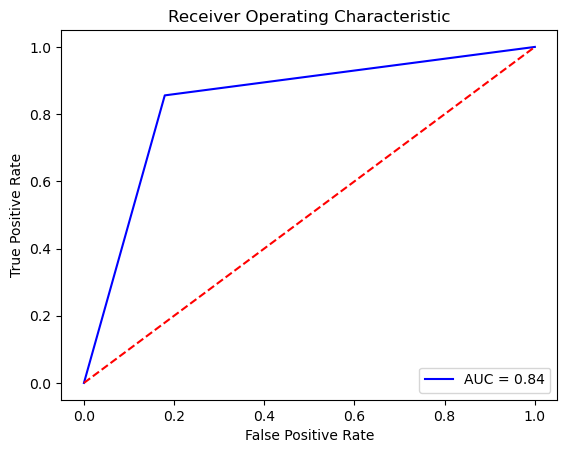

In [128]:
buildROC(y_test, model.predict(X_test))

#### 3.7 LightGBM

https://www.linkedin.com/pulse/boosting-techniques-battle-catboost-vs-xgboost-lightgbm-uttam-kumar/

In [129]:
!pip install lightgbm

* Gradient-based One-Side Sampling (GOSS) for faster training on large datasets
* 
Exclusive Feature Bundling (EFB) for feature transformation and dimension reductin
* 
Histogram-based Gradient Boosting (HGB) for faster and more efficient gradient calculation

In [130]:
import lightgbm as lgb

In [131]:
# Convert the data to LightGBM format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [132]:
import lightgbm as lgb

# Set the hyperparameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the model
num_rounds = 1000
model = lgb.train(params, train_data, num_rounds, valid_sets=[test_data])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [133]:
  # Precision
  from sklearn.metrics import precision_score
  precision = precision_score(y_test, y_pred)

In [134]:
from sklearn.metrics import accuracy_score, roc_auc_score
# Make predictions
y_pred = model.predict(X_test)
 
# Calculate accuracy and ROC AUC score
accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
roc_auc = roc_auc_score(y_test, y_pred)

 
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.8899852452969385
ROC AUC: 0.9589205913784188


In [136]:
from sklearn.metrics import mean_squared_error

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.2f}")

RMSE: 0.29


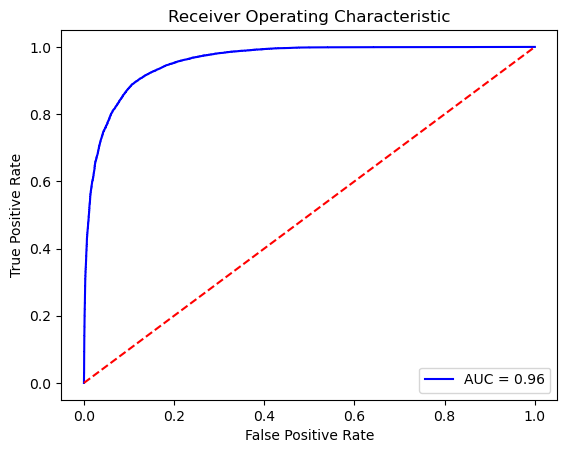

In [137]:
buildROC(y_test, model.predict(X_test))

In [138]:
model.predict(X_test)

array([0.31909945, 0.64747119, 0.56463837, ..., 0.98801416, 0.01523504,
       0.98426522])

In [139]:
np.average(model.predict(X_test))

0.483058887376406

#### 3.8 Gradient Boosting

In [140]:
from sklearn.ensemble import GradientBoostingClassifier


# Train a GradientBoosting classifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.83


In [141]:
pd.DataFrame(model.predict_proba(X_test))

,0,1
0,0.356284,0.643716
1,0.522062,0.477938
2,0.417277,0.582723
3,0.049230,0.950770
4,0.050913,0.949087
...,...,...
32527,0.988886,0.011114
32528,0.341150,0.658850
32529,0.062542,0.937458
32530,0.957111,0.042889


In [142]:
np.average(model.predict_proba(X_test)[:,1])

0.4823662175527396

Accuracy:  0.8271548014262879
Kappa:  0.6544585766963447
Precision:  0.8048988026499726
F1:  0.8248777601295587


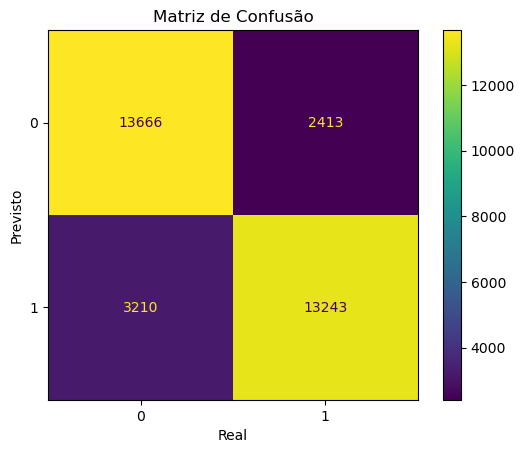

In [143]:
predict_and_evaluate(X_test, y_test)

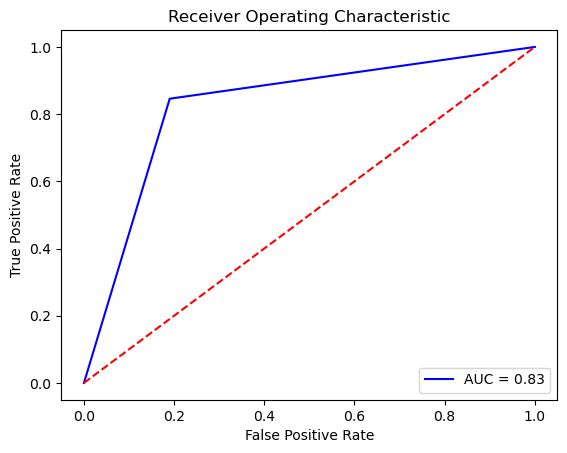

In [144]:
buildROC(y_test, model.predict(X_test))

#### 3.9 Hierarchical Gradient Boosting

In [145]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


C:\Users\marco\anaconda3\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [146]:
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

HistGradientBoostingRegressor()

In [147]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean squared error: {mse:.2f}')


Mean squared error: 0.10


In [148]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [149]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [150]:
# https://machinelearningmastery.com/histogram-based-gradient-boosting-ensembles/
# define the model
model = HistGradientBoostingClassifier(max_bins=255, max_iter=100)
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.866 (0.004)


In [151]:
model.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [152]:
pd.DataFrame(model.predict_proba(X_test))

,0,1
0,0.681331,0.318669
1,0.400741,0.599259
2,0.427036,0.572964
3,0.051390,0.948610
4,0.029877,0.970123
...,...,...
32527,0.999551,0.000449
32528,0.333579,0.666421
32529,0.052781,0.947219
32530,0.977457,0.022543


#### 3.10 XGBoost

In [153]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [154]:
def train(x_train, y_train, seed):
  model = xgb.XGBClassifier (random_state=seed) # tente mudar parâmetro para evitar overfitting
  model.fit(X_train, y_train, early_stopping_rounds = 10, eval_set=[(X_test,y_test)]);
  return model

model = train(X_train, y_train, seed)

C:\Users\marco\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.56671
[1]	validation_0-logloss:0.49787
[2]	validation_0-logloss:0.45334
[3]	validation_0-logloss:0.42654
[4]	validation_0-logloss:0.40734
[5]	validation_0-logloss:0.39427
[6]	validation_0-logloss:0.38412
[7]	validation_0-logloss:0.37314
[8]	validation_0-logloss:0.36717
[9]	validation_0-logloss:0.36407
[10]	validation_0-logloss:0.36059
[11]	validation_0-logloss:0.35840
[12]	validation_0-logloss:0.34920
[13]	validation_0-logloss:0.34761
[14]	validation_0-logloss:0.34419
[15]	validation_0-logloss:0.34163
[16]	validation_0-logloss:0.34091
[17]	validation_0-logloss:0.33539
[18]	validation_0-logloss:0.33489
[19]	validation_0-logloss:0.33376
[20]	validation_0-logloss:0.33193
[21]	validation_0-logloss:0.33036
[22]	validation_0-logloss:0.32912
[23]	validation_0-logloss:0.32780
[24]	validation_0-logloss:0.32059
[25]	validation_0-logloss:0.31840
[26]	validation_0-logloss:0.31585
[27]	validation_0-logloss:0.31510
[28]	validation_0-logloss:0.31475
[29]	validation_0-loglos

Accuracy:  0.8820545924013279
Kappa:  0.7641380053441095
Precision:  0.8621239046510203
F1:  0.88


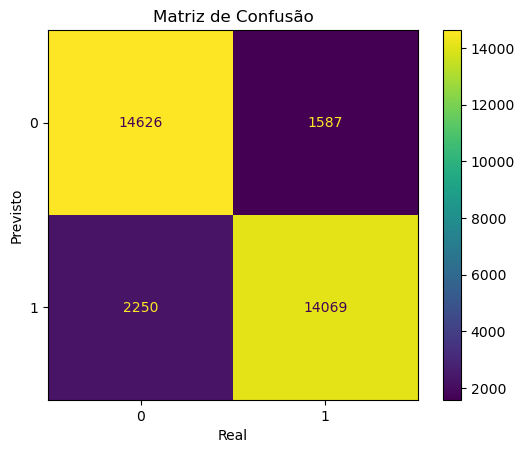

In [155]:
predict_and_evaluate(X_test, y_test)

In [156]:
pd.DataFrame(model.predict_proba(X_test)).to_csv('xgboosting_xtest.csv', sep =';')

In [157]:
pd.DataFrame(model.predict_proba(X_train)).to_csv('xgboosting_xtrain.csv', sep =';')

In [158]:
np.average(model.predict_proba(X_test)[:,1])

0.48327252

In [159]:
base_efetividade_acoes

,ACAO,QTDE_ACOES,QTDE_EFET_ACOES,EFETIVIDADE (%)
0,acao_1,5520,107,1.938406
1,acao_10,185927,22953,12.345168
2,acao_11,500,4,0.800000
3,acao_12,212375,20106,9.467216
4,acao_13,33594,1512,4.500804
5,acao_14,79194,3171,4.004091
6,acao_15,13377,754,5.636540
7,acao_2,131084,43404,33.111593
8,acao_3,327167,21639,6.614053
9,acao_4,1140471,16367,1.435109


In [161]:
base_efetividade_acoes.loc[(base_efetividade_acoes['ACAO'] == "acao_7")].iloc[0,-1]

48.12521901647004

É possível observar que a média das probabilidades pode ser usada para ser um estimador da média de retorno esperado do modelo treinado. Além disso, calculando a variância/desvio dessa amostra, é possível construir intervalos de confiança, considerando um intervalo de confiança de 95%.


Temos que a média E[prob]: 0.48

In [162]:
len(model.predict_proba(X_test)[:,1])

32532

In [163]:
import scipy.stats as stats

media = np.average(model.predict_proba(X_test)[:,1]*100)
desvio_padrao = stats.tstd(model.predict_proba(X_test)[:,1]*100)
graus_liberdade = len(model.predict_proba(X_test)[:,1]) - 1

intervalo_confianca = stats.t.interval(0.95, graus_liberdade, loc=media, scale=desvio_padrao)

In [164]:
intervalo_confianca

(-28.93005304428975, 125.5845559129421)

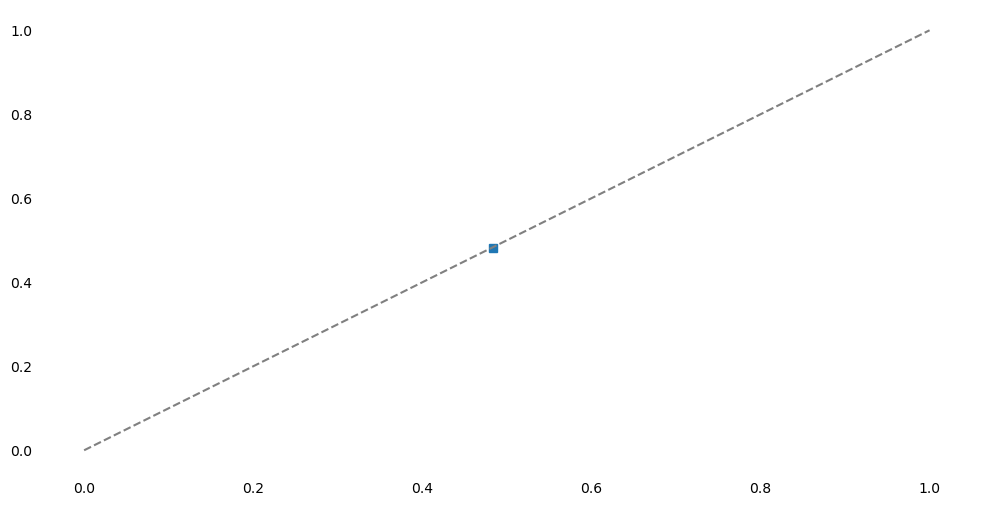

In [166]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(np.average(model.predict_proba(X_test)[:,1]), base_efetividade_acoes.loc[(base_efetividade_acoes['ACAO'] == "acao_7")].iloc[0,-1]/100, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
#plt.title("$LogisticRegression$ Calibration Curve", fontsize=20); pass

In [167]:
model.predict_proba(X_test)

array([[0.6276809 , 0.37231907],
       [0.38531786, 0.61468214],
       [0.42686522, 0.5731348 ],
       ...,
       [0.02240074, 0.97759926],
       [0.99396515, 0.00603486],
       [0.02061796, 0.97938204]], dtype=float32)

In [168]:
model.predict_proba(X_test)[:,1]

array([0.37231907, 0.61468214, 0.5731348 , ..., 0.97759926, 0.00603486,
       0.97938204], dtype=float32)

https://select-statistics.co.uk/blog/assessing-and-improving-probability-prediction-models/

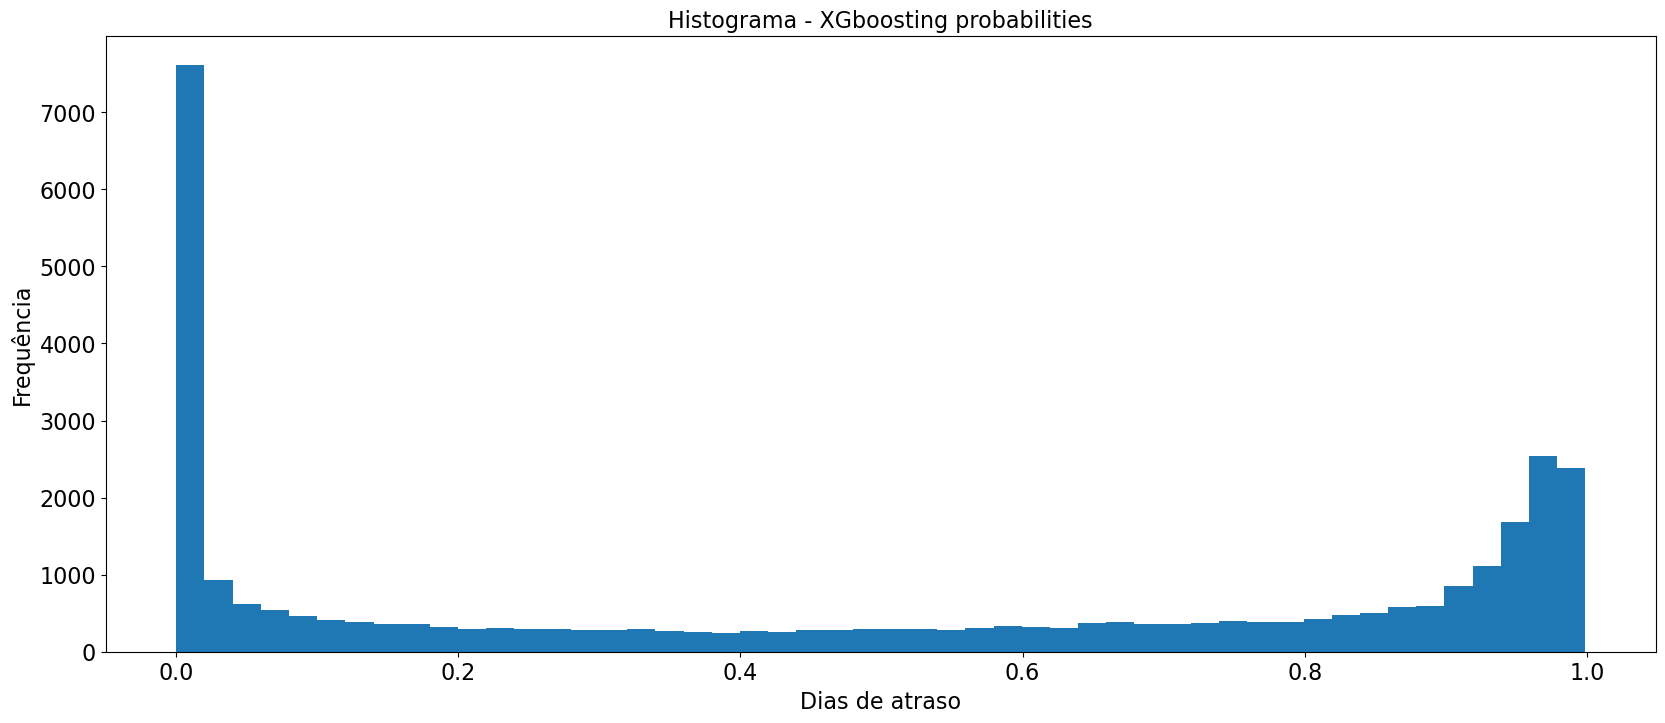

In [169]:
%matplotlib inline
fig, ax = plt.subplots(ncols=1,figsize=(20, 8))

plt.hist(np.clip(model.predict_proba(X_test)[:,1], 0, 300), density=False, bins=50)  # density=False would make counts
plt.ylabel('Frequência', size = 16)
plt.xlabel('Dias de atraso', size = 16);
plt.title('Histograma - XGboosting probabilities', size = 16)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.show()

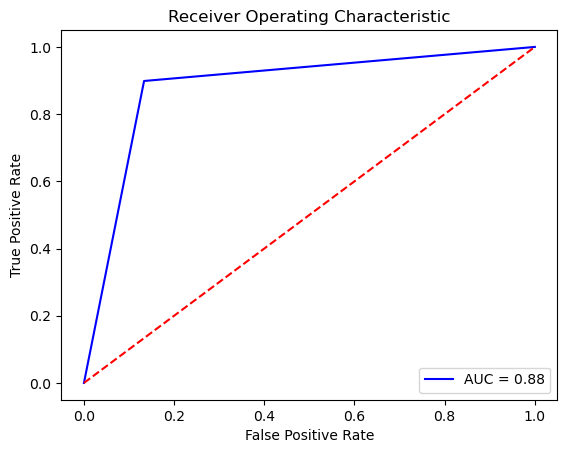

In [170]:
buildROC(y_test, model.predict(X_test))

O limiar (threshold) padrão dos modelos de XGboosting é de 0.5.

In [171]:
threshold_limiar = 0.4
y_val_predict_prob = model.predict_proba(X_test)[:,1]
y_val_predict = (y_val_predict_prob > threshold_limiar).astype(int)

In [172]:
y_val_predict.sum()

17711

In [173]:
# same seed for reproduction and comparison of results
seed = 1
random.seed(seed)
np.random.seed(seed)

In [174]:
X = master_table.loc[:,master_table.columns != 'ACAO_EFETIVA']  # Entrada
y = master_table.ACAO_EFETIVA    # Saída
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

## Model Calibration - Probabilities

Uma vez que estamos interessados não em dizer se uma ação foi efetiva ou não e sim nas probabilidades estimadas pelos modelos, a métrica de performance dos modelos de classificação não é suficiente para dizermos que o modelo está bem comportado. Assim sendo, é possível utilizar informações para avaliar a calibragem dos modelos.

In [182]:
from sklearn.calibration import CalibrationDisplay


In [183]:
y_test_predict_proba = model.predict_proba(X_test)[:, 1]

In [184]:
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)

In [185]:
fraction_of_positives

array([0.00983381, 0.1171024 , 0.20081411, 0.30104322, 0.41091954,
       0.53038309, 0.67633675, 0.77586207, 0.8805395 , 0.97294448])

In [186]:
mean_predicted_value

array([0.01543212, 0.14750645, 0.24917053, 0.34845631, 0.45128317,
       0.55142858, 0.6520568 , 0.75122215, 0.85384105, 0.95997221])

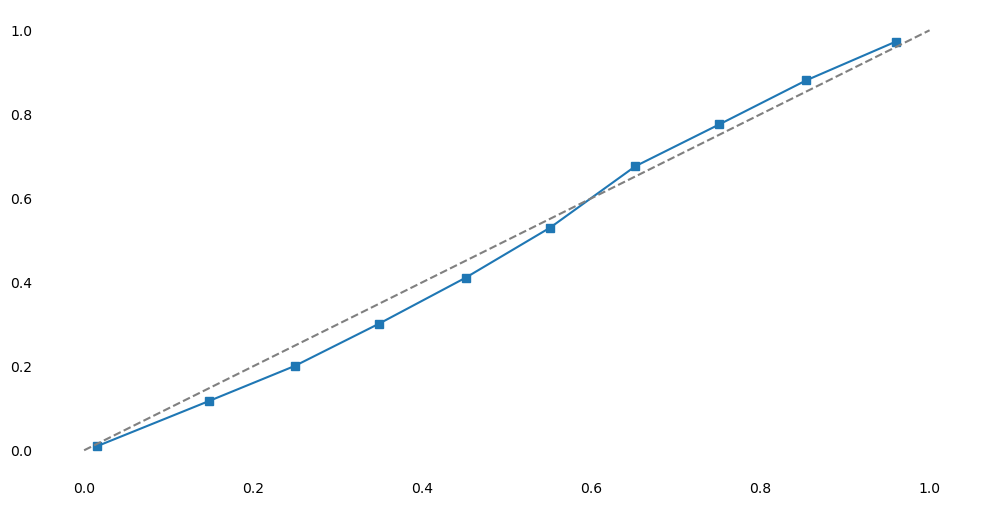

In [187]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')

sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
#plt.title("$LogisticRegression$ Calibration Curve", fontsize=20); pass

In [188]:
#https://medium.com/analytics-vidhya/how-probability-calibration-works-a4ba3f73fd4d
#https://ploomber.io/blog/calibration-curve/
#https://towardsdatascience.com/a-comprehensive-guide-on-model-calibration-part-1-of-4-73466eb5e09a

In [189]:
# get the probability to belonging to the positive class
prob_positive = model.predict_proba(X_test)[:, 1]

# data frame with probabilities and actual labels
df = pd.DataFrame({'prob': prob_positive, 'actual': y_test})

# bin probabilities
df['prob_bin'] = pd.cut(df.prob, bins=np.arange(0, 1.1, 0.1))

df.groupby('prob_bin').actual.mean()

C:\Users\marco\AppData\Local\Temp\ipykernel_28804\2322815547.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('prob_bin').actual.mean()


prob_bin
(0.0, 0.1]    0.009834
(0.1, 0.2]    0.117102
(0.2, 0.3]    0.200814
(0.3, 0.4]    0.301043
(0.4, 0.5]    0.410920
(0.5, 0.6]    0.530383
(0.6, 0.7]    0.676337
(0.7, 0.8]    0.775862
(0.8, 0.9]    0.880539
(0.9, 1.0]    0.972944
Name: actual, dtype: float64

**Calculating RMSE (Root-mean-square deviation):**

In [195]:
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print("RMSE: %f" % (rmse))

RMSE: 0.343432


**Feature importance**

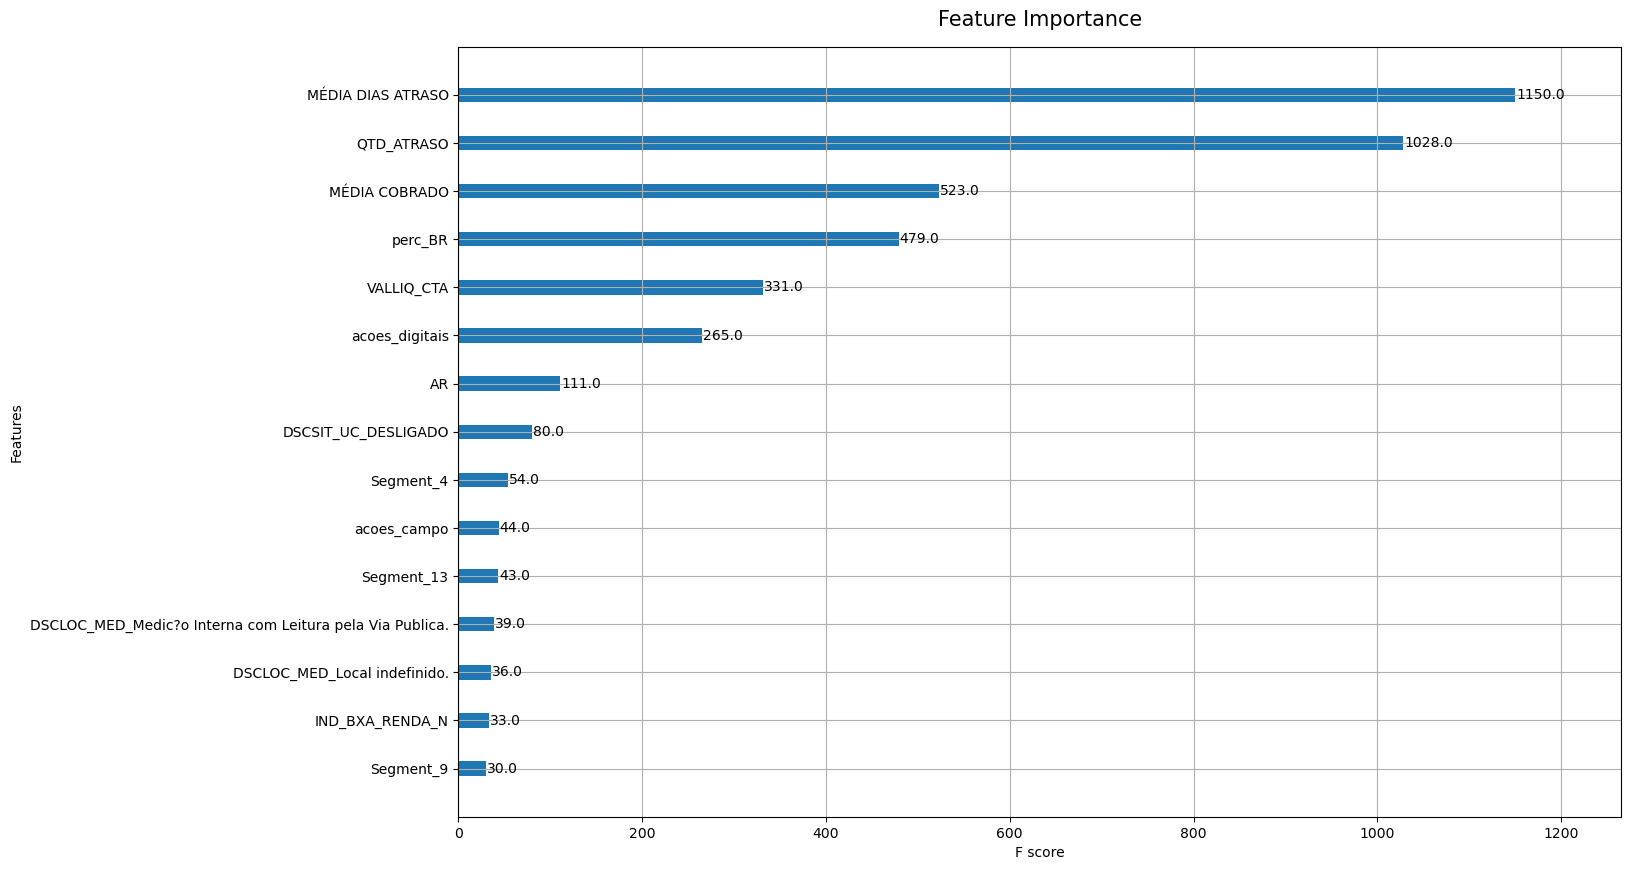

In [196]:
fig, ax = plt.subplots(figsize=(15,10))
xgb.plot_importance(model, ax = ax, max_num_features=15, height = 0.3, show_values = True)
ax.set_ylabel('Features',fontsize = 10)
ax.set_xlabel('F score',fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.set_title('Feature Importance', size=15,pad=15)
plt.show()

#for i, v in enumerate(y):
#    ax.text(v + 3, i, str(y), color='black', size = 28)


#### PCA - Técnica de Redução de Dimensionalidade

Técnicas para evitar o overfitting dos modelos: divisão do conjunto em treino e em teste, a regularização (modelos de penalização por seleção de variáveis como a regressão Lasso e Ridge), validação cruzada, seleção de atributos (feature importance e PCA).

In [197]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
df = pd.DataFrame(pca.explained_variance_ratio_.cumsum())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)

          0
0   0.99999
1   1.00000
2   1.00000
3   1.00000
4   1.00000
5   1.00000
6   1.00000
7   1.00000
8   1.00000
9   1.00000
10  1.00000
11  1.00000
12  1.00000
13  1.00000
14  1.00000
15  1.00000
16  1.00000
17  1.00000
18  1.00000
19  1.00000
20  1.00000
21  1.00000
22  1.00000
23  1.00000
24  1.00000
25  1.00000
26  1.00000
27  1.00000
28  1.00000
29  1.00000
30  1.00000
31  1.00000
32  1.00000
33  1.00000
34  1.00000
35  1.00000
36  1.00000
37  1.00000
38  1.00000
39  1.00000
40  1.00000
41  1.00000
42  1.00000
43  1.00000
44  1.00000
45  1.00000
46  1.00000
47  1.00000
48  1.00000
49  1.00000
50  1.00000
51  1.00000
52  1.00000
53  1.00000
54  1.00000
55  1.00000
56  1.00000
57  1.00000
58  1.00000


In [198]:
# 214
cut = 2
x_train_pca = pca.transform(X_train)
x_train_pca = x_train_pca[:, 0:cut]
x_train_pca.shape

(130127, 2)

In [199]:
x_test_pca = pca.transform(X_test)
x_test_pca = x_test_pca[:, 0:cut]
x_test_pca.shape

(32532, 2)

In [200]:
# training SVM model
def train(x_train, y_train, seed):
  model = xgb.XGBClassifier (random_state=seed) # tente mudar parâmetro para evitar overfitting
  model.fit(x_train_pca, y_train, early_stopping_rounds = 10, eval_set=[(x_test_pca,y_test)]);
  return model

model = train(x_train_pca, y_train, seed)

[0]	validation_0-logloss:0.60890
[1]	validation_0-logloss:0.56447
[2]	validation_0-logloss:0.53933
[3]	validation_0-logloss:0.52418
[4]	validation_0-logloss:0.51465
[5]	validation_0-logloss:0.50837
[6]	validation_0-logloss:0.50448
[7]	validation_0-logloss:0.50169
[8]	validation_0-logloss:0.49983
[9]	validation_0-logloss:0.49848
[10]	validation_0-logloss:0.49748
[11]	validation_0-logloss:0.49681
[12]	validation_0-logloss:0.49619
[13]	validation_0-logloss:0.49582
[14]	validation_0-logloss:0.49539
[15]	validation_0-logloss:0.49516
[16]	validation_0-logloss:0.49504
[17]	validation_0-logloss:0.49489
[18]	validation_0-logloss:0.49477
[19]	validation_0-logloss:0.49467
[20]	validation_0-logloss:0.49466
[21]	validation_0-logloss:0.49464
[22]	validation_0-logloss:0.49458
[23]	validation_0-logloss:0.49452
[24]	validation_0-logloss:0.49450
[25]	validation_0-logloss:0.49452


C:\Users\marco\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.49452
[27]	validation_0-logloss:0.49444
[28]	validation_0-logloss:0.49440
[29]	validation_0-logloss:0.49437
[30]	validation_0-logloss:0.49434
[31]	validation_0-logloss:0.49429
[32]	validation_0-logloss:0.49425
[33]	validation_0-logloss:0.49425
[34]	validation_0-logloss:0.49433
[35]	validation_0-logloss:0.49435
[36]	validation_0-logloss:0.49436
[37]	validation_0-logloss:0.49437
[38]	validation_0-logloss:0.49437
[39]	validation_0-logloss:0.49441
[40]	validation_0-logloss:0.49445
[41]	validation_0-logloss:0.49449
[42]	validation_0-logloss:0.49453


Accuracy:  0.7494774375999016
Kappa:  0.4991811858570969
Precision:  0.7279795893573078
F1:  0.7462482097266331


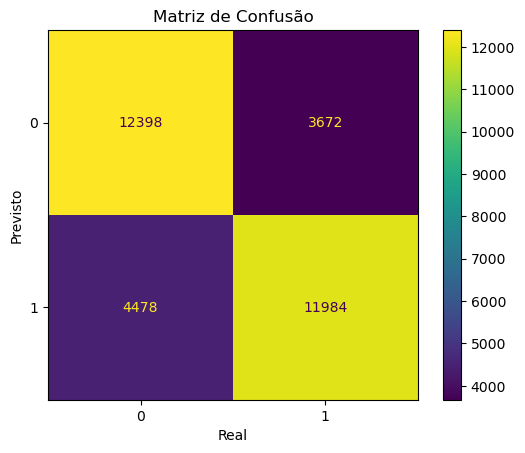

In [201]:
predict_and_evaluate(x_test_pca, y_test)

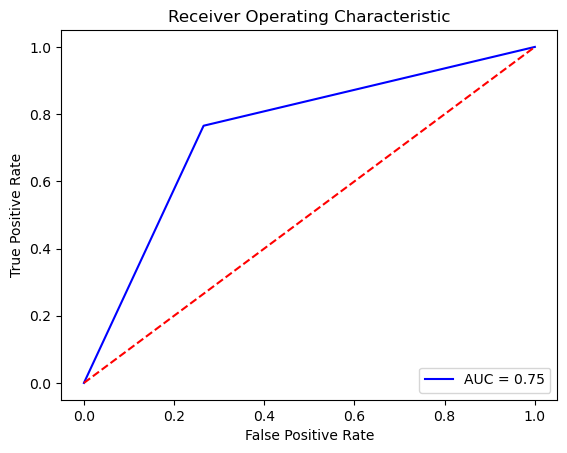

In [202]:
buildROC(y_test, model.predict(x_test_pca))

## Conclusão

**Decisão do modelo** - A partir da modelagem para acao_7, foi realizado treinamento dos modelos indo das técnicas de algoritmo mais simples até os modelos baseado em árvores mais robustos, como os modelos de XGBoosting e Catboost. A priori, após análises das métricas e calibragem dos modelos em relação às probabilidades estimadas, o modelo XGBoosting mostrou performance superior aos demais.

**Modelo NBA** - A partir do modelo selecionado, os demais modelos também devem ser treinados para cada uma das ações de cobrança de forma que com  a fórmula de Retorno Esperado, seja possível priorizar uma lista de acordo com a as melhores ações de cobrança.

Assim, tem-se: 

**Fórmula sugerida:**

ROI = [(Debt_customer * Prob(pagar)) - C(ação)]/C(ação)


Debt_customer = Dívida do cliente
Prob(pagar) = Probabilidade do cliente reagir à ação de cobrança - pagar a conta
C(ação) = custo da ação